## Set up before acquiring data!

In [1]:
"""
Updated, 07-02-2025

@author: Dean Waldow

START HERE!

Modified code to use Avantes Spectrometer
Currently using Anaconda Env SpecEchem 2023.

"""
#
#  Working Candidate for Spec E Chem
#  • for one run in conjunction with the Gamry
#  ??? Maybe not true with the Avantes  "will need to change trigger mode to 4 in one spot"
#  • need to get this setup as a class or function and combine
#    with number of echem points and number of runs.
#

import os
import platform
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from pathlib import Path
import globals
from avaspec import *
import pickle
import warnings


In [2]:
# Avantes class for Spectroelectrochemistry
#  Dean Waldow, July 2025
#  * changed output of data to a numpy array for wavelengths ~380 to ~1100 nm
#
class Avantes:
    def ___init_(self):
        pass

    def init(self):
        ret = AVS_Init(0)    
        print("AVS_Init returned:  {0:d}".format(ret))
        ret = AVS_GetNrOfDevices()
        print("AVS_GetNrOfDevices returned:  {0:d}".format(ret))
        mylist = AvsIdentityType()
        mylist = AVS_GetList(1)
        serienummer = str(mylist[0].SerialNumber.decode("utf-8"))
        print("Found Serialnumber: " + serienummer)
        globals.dev_handle = AVS_Activate(mylist[0])
        print("AVS_Activate returned:  {0:d}".format(globals.dev_handle))
        devcon = DeviceConfigType()
        devcon = AVS_GetParameter(globals.dev_handle, 63484)
        globals.pixels = devcon.m_Detector_m_NrPixels
        globals.wavelength = AVS_GetLambda(globals.dev_handle)
        ret = AVS_UseHighResAdc(globals.dev_handle, True)
        measconfig = MeasConfigType()
        measconfig.m_StartPixel = 0
        measconfig.m_StopPixel = globals.pixels - 1
        measconfig.m_IntegrationTime = 0.022 # initial int time
        measconfig.m_IntegrationDelay = 0
        measconfig.m_NrAverages = 200 # Varius Spect. is about 80 ms
        measconfig.m_CorDynDark_m_Enable = 0  # nesting of types does NOT work!!
        measconfig.m_CorDynDark_m_ForgetPercentage = 0
        measconfig.m_Smoothing_m_SmoothPix = 0
        measconfig.m_Smoothing_m_SmoothModel = 0
        measconfig.m_SaturationDetection = 0
        measconfig.m_Trigger_m_Mode = 0
        measconfig.m_Trigger_m_Source = 0
        measconfig.m_Trigger_m_SourceType = 0
        measconfig.m_Control_m_StrobeControl = 0
        measconfig.m_Control_m_LaserDelay = 0
        measconfig.m_Control_m_LaserWidth = 0
        measconfig.m_Control_m_LaserWaveLength = 0.0
        measconfig.m_Control_m_StoreToRam = 0
        ret = AVS_PrepareMeasure(globals.dev_handle, measconfig)
        return measconfig, serienummer  
    
    def wavelengths(self):
        wavelength = AVS_GetLambda(globals.dev_handle)
        return wavelength, np.array(wavelength[395:1660])
    
    def measure_timing(self,measconfig):
        nummeas = 1
        scans = 0
        globals.stopscanning = False
        while (globals.stopscanning == False):
            t1 = time.time()
            #print("before",t1)
            ret = AVS_Measure(globals.dev_handle, 0, 1)
            dataready = False
            while (dataready == False):
                dataready = (AVS_PollScan(globals.dev_handle) == True)
                time.sleep(0.001)      
            if dataready == True:
                scans = scans + 1
            if (scans >= nummeas):
                globals.stopscanning = True
            timestamp = 0
            ret = AVS_GetScopeData(globals.dev_handle)
            t2 = time.time()
            t_dif = t2-t1
            #print("after",t2)
            #print("Difference(ms): ",f"{t_dif*1000:.4g}", "Total Int Time (ms) = ", measconfig.m_IntegrationTime*measconfig.m_NrAverages)
            #print("Net Dif(ms): ",f"{(t_dif*1000 -measconfig.m_IntegrationTime*measconfig.m_NrAverages):.4g}")
            timestamp = ret[0]
            globals.spectraldata = ret[1]
    
            #print("\n\n Start of DW's section\n\n")
            #print("Received timestamp: {0:d}".format(timestamp))
            #print("Timing from Avantes: ", )
            scans = 1
            t1 = time.time()
            #print("before",t1)
            AVS_Measure(globals.dev_handle, 0, scans)
            dataready = False
            while not dataready:
                dataready = AVS_PollScan(globals.dev_handle)
                time.sleep(0.001)
            ret = AVS_GetScopeData(globals.dev_handle)
            t2 = time.time()
            t_dif = t2-t1
            #print("after",t2)
            #print("Difference(ms): ",f"{t_dif*1000:.4g}", "Total Int Time (ms) = ",measconfig.m_IntegrationTime*measconfig.m_NrAverages)
            net_dif = t_dif*1000 -measconfig.m_IntegrationTime*measconfig.m_NrAverages
            #print("Net Dif(ms): ",f"{(net_dif):.4g}")
            timestamp = ret[0]
            #print("Timestamp = ",timestamp)
            spectraldata2 = ret[1]
            #print("Max = ",max(spectraldata2))
            type(spectraldata2)
        return timestamp, np.array(spectraldata2[395:1660]), net_dif, t_dif
    
    def measure(self):  #  returns timestamp and spectrum from 1 scan - no frills!
        nummeas = 1
        scans = 0
        globals.stopscanning = False
        while (globals.stopscanning == False):
            ret = AVS_Measure(globals.dev_handle, 0, 1)
            dataready = False
            while (dataready == False):
                dataready = (AVS_PollScan(globals.dev_handle) == True)
                time.sleep(0.001)      
            if dataready == True:
                scans = scans + 1
            if (scans >= nummeas):
                globals.stopscanning = True
            ret = AVS_GetScopeData(globals.dev_handle)
            timestamp = ret[0]
            globals.spectraldata = ret[1]
            spectraldata2 = ret[1]
        return timestamp, np.array(spectraldata2[395:1660])
    
    def plot_data(self, wavelength, spectraldata):
        plt.plot(wavelength, spectraldata) 
        #plt.xlim(400,1100)
        return
    
    def set_int_time(self, measconfig, duration):
        measconfig.m_IntegrationTime = duration
        ret = AVS_PrepareMeasure(globals.dev_handle, measconfig)
        return
    
    def set_trig_mode(self, measconfig, mode):  # mode = 0: no trigger, mode = 1: edge trigger
        measconfig.m_Trigger_m_Mode = mode
        ret = AVS_PrepareMeasure(globals.dev_handle, measconfig)
        return
    
    def set_source_type(self, measconfig, mode):  # mode = 0: edge trigger, mode = 1: level trigger
        measconfig.m_Trigger_m_SourceType = mode
        ret = AVS_PrepareMeasure(globals.dev_handle, measconfig)
        return
    
    def set_scan_aves(self, measconfig, scans):
        measconfig.m_NrAverages = scans
        ret = AVS_PrepareMeasure(globals.dev_handle, measconfig)
        return

In [3]:
import numpy as np
import os
import json
from datetime import datetime
import matplotlib.pyplot as plt

def setup(wavelength, skip_dark=False, save_spectra=True, load_existing=False, 
          data_dir="spectra_data", file_prefix="", load_dark_only=False, load_ref_only=False,
          existing_dark=None, existing_ref=None):
    """
    Collect Dark and Reference Spectra with save/load functionality.
    
    This function can either collect new spectra or load previously saved ones.
    When collecting new spectra, it can optionally save them for future use.
    Now supports selective loading of only dark or only reference spectra.
    
    Args:
        wavelength: Wavelength array for plotting
        skip_dark (bool): If True, skip dark spectrum collection
        save_spectra (bool): If True, save collected spectra to files
        load_existing (bool): If True, attempt to load existing spectra instead of collecting
        data_dir (str): Directory to save/load spectra files
        file_prefix (str): Prefix for saved files (useful for different experiments)
        load_dark_only (bool): If True, only load dark spectrum (keeps existing ref)
        load_ref_only (bool): If True, only load reference spectrum (keeps existing dark)
        existing_dark: Previously loaded dark spectrum to preserve
        existing_ref: Previously loaded reference spectrum to preserve
        
    Returns:
        tuple: (dark, ref) - Dark and reference spectra arrays
    """
    # Initialize variables - use existing spectra if provided
    data0 = 0
    ref = existing_ref if existing_ref is not None else 0
    dark = existing_dark if existing_dark is not None else 0
    
    # Create data directory if it doesn't exist
    if save_spectra or load_existing:
        os.makedirs(data_dir, exist_ok=True)
    
    # Generate filenames
    timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
    if file_prefix:
        dark_filename = f"{file_prefix}_dark_{timestamp_str}.npz"
        ref_filename = f"{file_prefix}_ref_{timestamp_str}.npz"
        metadata_filename = f"{file_prefix}_metadata_{timestamp_str}.json"
    else:
        dark_filename = f"dark_{timestamp_str}.npz"
        ref_filename = f"ref_{timestamp_str}.npz"
        metadata_filename = f"metadata_{timestamp_str}.json"
    
    dark_filepath = os.path.join(data_dir, dark_filename)
    ref_filepath = os.path.join(data_dir, ref_filename)
    metadata_filepath = os.path.join(data_dir, metadata_filename)
    
    # ============================================================================
    # LOAD EXISTING SPECTRA
    # ============================================================================
    
    if load_existing:
        print("Looking for existing spectra files...")
        
        # Determine what to load based on flags
        if load_dark_only and load_ref_only:
            print("Warning: Both load_dark_only and load_ref_only are True. Loading both.")
            load_target = "both"
        elif load_dark_only:
            load_target = "dark"
            print("Loading dark spectrum only (preserving existing reference)...")
        elif load_ref_only:
            load_target = "ref"
            print("Loading reference spectrum only (preserving existing dark)...")
        else:
            load_target = "both"
            print("Loading both dark and reference spectra...")
        
        # List available files
        available_files = []
        for file in os.listdir(data_dir):
            if file.endswith('.npz'):
                # Filter files based on what we want to load
                if load_target == "dark" and '_dark_' in file:
                    available_files.append(file)
                elif load_target == "ref" and '_ref_' in file:
                    available_files.append(file)
                elif load_target == "both" and ('_dark_' in file or '_ref_' in file):
                    available_files.append(file)
        
        if not available_files:
            print(f"No existing {load_target} files found. Proceeding to collect new spectra.")
            load_existing = False
        else:
            print(f"\nAvailable {load_target} files:")
            
            if load_target == "both":
                # Group files by timestamp/prefix for both dark and ref
                file_groups = {}
                for file in available_files:
                    # Extract base name (without dark/ref designation)
                    if '_dark_' in file:
                        base_name = file.replace('_dark_', '_')
                    elif '_ref_' in file:
                        base_name = file.replace('_ref_', '_')
                    else:
                        base_name = file
                    
                    if base_name not in file_groups:
                        file_groups[base_name] = []
                    file_groups[base_name].append(file)
                
                # Display grouped files
                for i, (base_name, files) in enumerate(file_groups.items()):
                    print(f"{i+1}. {base_name} - Files: {files}")
                
            else:
                # Just list individual files for single type loading
                for i, file in enumerate(available_files):
                    print(f"{i+1}. {file}")
            
            try:
                choice = input(f"\nEnter number to load existing {load_target} spectrum/spectra, or 'n' for new: ")
                if choice.lower() == 'n':
                    load_existing = False
                else:
                    choice_idx = int(choice) - 1
                    
                    if load_target == "both":
                        selected_files = list(file_groups.values())[choice_idx]
                        
                        # Load the selected files
                        dark_file = None
                        ref_file = None
                        
                        for file in selected_files:
                            if '_dark_' in file:
                                dark_file = file
                            elif '_ref_' in file:
                                ref_file = file
                        
                        # Load dark spectrum
                        if dark_file and not skip_dark:
                            dark_path = os.path.join(data_dir, dark_file)
                            try:
                                loaded_dark_data = np.load(dark_path)
                                dark = loaded_dark_data['spectrum']
                                print(f"Loaded dark spectrum from: {dark_file}")
                                
                                # Plot loaded dark spectrum
                                plt.figure(figsize=(10, 6))
                                spec.plot_data(wavelength, dark)
                                plt.title(f"Loaded Dark Spectrum - {dark_file}")
                                plt.show()
                            except Exception as e:
                                print(f"Error loading dark spectrum: {e}")
                        
                        # Load reference spectrum
                        if ref_file:
                            ref_path = os.path.join(data_dir, ref_file)
                            try:
                                loaded_ref_data = np.load(ref_path)
                                ref = loaded_ref_data['spectrum']
                                print(f"Loaded reference spectrum from: {ref_file}")
                                
                                # Plot loaded reference spectrum
                                plt.figure(figsize=(10, 6))
                                spec.plot_data(wavelength, ref)
                                plt.title(f"Loaded Reference Spectrum - {ref_file}")
                                plt.show()
                            except Exception as e:
                                print(f"Error loading reference spectrum: {e}")
                    
                    else:
                        # Loading single file (dark only or ref only)
                        selected_file = available_files[choice_idx]
                        file_path = os.path.join(data_dir, selected_file)
                        
                        try:
                            loaded_data = np.load(file_path)
                            loaded_spectrum = loaded_data['spectrum']
                            
                            if load_target == "dark":
                                dark = loaded_spectrum
                                print(f"Loaded dark spectrum from: {selected_file}")
                                print(f"Preserving existing reference spectrum.")
                                
                                # Plot loaded dark spectrum
                                plt.figure(figsize=(10, 6))
                                spec.plot_data(wavelength, dark)
                                plt.title(f"Loaded Dark Spectrum - {selected_file}")
                                plt.show()
                                
                            elif load_target == "ref":
                                ref = loaded_spectrum
                                print(f"Loaded reference spectrum from: {selected_file}")
                                print(f"Preserving existing dark spectrum.")
                                
                                # Plot loaded reference spectrum
                                plt.figure(figsize=(10, 6))
                                spec.plot_data(wavelength, ref)
                                plt.title(f"Loaded Reference Spectrum - {selected_file}")
                                plt.show()
                                
                        except Exception as e:
                            print(f"Error loading {load_target} spectrum: {e}")
                            load_existing = False
                    
                    # Check if we have what we need
                    dark_ok = (dark is not None and not isinstance(dark, int)) or skip_dark
                    ref_ok = (ref is not None and not isinstance(ref, int))
                    
                    if dark_ok and ref_ok:
                        print("Successfully loaded spectra!")
                        return dark, ref
                    else:
                        missing = []
                        if not dark_ok and not skip_dark:
                            missing.append("dark")
                        if not ref_ok:
                            missing.append("reference")
                        print(f"Missing {', '.join(missing)} spectrum/spectra. Collecting new spectra.")
                        load_existing = False
                        
            except (ValueError, IndexError):
                print("Invalid selection. Collecting new spectra.")
                load_existing = False
    
    # ============================================================================
    # COLLECT NEW SPECTRA
    # ============================================================================
    
    if not load_existing:
        print("Collecting new spectra...")
        
        # Collect Dark Spectrum (only if we don't already have one or if not preserving)
        need_dark = (not skip_dark and 
                    (not load_ref_only or dark is None or isinstance(dark, int)))
        
        if need_dark:
            print("\n" + "="*50)
            print("DARK SPECTRUM COLLECTION")
            print("="*50)
            goDark = input("Hit ENTER to collect Dark Spectrum: ")
            
            timestamp, dark = spec.measure()
            
            # Plot dark spectrum
            plt.figure(figsize=(10, 6))
            spec.plot_data(wavelength, dark)
            plt.title("Dark Spectrum")
            plt.ylabel("Intensity")
            plt.xlabel("Wavelength (nm)")
            plt.grid(True, alpha=0.3)
            plt.show()
            
            # Save dark spectrum if requested
            if save_spectra:
                np.savez(dark_filepath, 
                        spectrum=dark, 
                        wavelength=wavelength,
                        timestamp=timestamp,
                        spectrum_type='dark')
                print(f"Dark spectrum saved to: {dark_filepath}")
                
        elif skip_dark:
            print("Skipped Dark Scan")
            dark = None
        elif load_ref_only and dark is not None:
            print("Preserving existing dark spectrum")
        
        # Collect Reference Spectrum (only if we don't already have one or if not preserving)
        need_ref = (not load_dark_only or ref is None or isinstance(ref, int))
        
        if need_ref:
            print("\n" + "="*50)
            print("REFERENCE SPECTRUM COLLECTION")
            print("="*50)
            goRef = input("Hit ENTER to collect Reference Spectrum: ")
            
            timestamp, ref = spec.measure()
            
            # Plot reference spectrum
            plt.figure(figsize=(10, 6))
            spec.plot_data(wavelength, ref)
            plt.title("Reference Spectrum")
            plt.ylabel("Intensity")
            plt.xlabel("Wavelength (nm)")
            plt.grid(True, alpha=0.3)
            plt.show()
            plt.pause(0.1)
            
            # Save reference spectrum if requested
            if save_spectra:
                np.savez(ref_filepath, 
                        spectrum=ref, 
                        wavelength=wavelength,
                        timestamp=timestamp,
                        spectrum_type='reference')
                print(f"Reference spectrum saved to: {ref_filepath}")
                
                # Save metadata
                metadata = {
                    'collection_date': datetime.now().isoformat(),
                    'skip_dark': skip_dark,
                    'dark_file': dark_filename if not skip_dark else None,
                    'ref_file': ref_filename,
                    'file_prefix': file_prefix,
                    'wavelength_range': {
                        'min': float(wavelength.min()),
                        'max': float(wavelength.max()),
                        'points': len(wavelength)
                    }
                }
                
                with open(metadata_filepath, 'w') as f:
                    json.dump(metadata, f, indent=2)
                print(f"Metadata saved to: {metadata_filepath}")
        elif load_dark_only and ref is not None:
            print("Preserving existing reference spectrum")
    
    return dark, ref


def list_saved_spectra(data_dir="spectra_data"):
    """
    List all saved spectra files with their details.
    
    Args:
        data_dir (str): Directory containing saved spectra
    """
    if not os.path.exists(data_dir):
        print(f"Data directory '{data_dir}' does not exist.")
        return
    
    files = [f for f in os.listdir(data_dir) if f.endswith('.npz')]
    
    if not files:
        print("No saved spectra files found.")
        return
    
    print(f"\nSaved spectra in '{data_dir}':")
    print("-" * 60)
    
    for file in sorted(files):
        filepath = os.path.join(data_dir, file)
        try:
            data = np.load(filepath)
            spectrum_type = data.get('spectrum_type', 'unknown')
            timestamp = data.get('timestamp', 'unknown')
            
            # Get file modification time as fallback
            mod_time = datetime.fromtimestamp(os.path.getmtime(filepath))
            
            print(f"File: {file}")
            print(f"  Type: {spectrum_type}")
            print(f"  Timestamp: {timestamp}")
            print(f"  Modified: {mod_time.strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"  Size: {len(data['spectrum'])} points")
            print()
            
        except Exception as e:
            print(f"File: {file} - Error reading: {e}")


def cleanup_old_spectra(data_dir="spectra_data", days_old=30):
    """
    Remove spectra files older than specified days.
    
    Args:
        data_dir (str): Directory containing saved spectra
        days_old (int): Remove files older than this many days
    """
    if not os.path.exists(data_dir):
        print(f"Data directory '{data_dir}' does not exist.")
        return
    
    cutoff_time = datetime.now().timestamp() - (days_old * 24 * 60 * 60)
    removed_files = []
    
    for file in os.listdir(data_dir):
        if file.endswith(('.npz', '.json')):
            filepath = os.path.join(data_dir, file)
            if os.path.getmtime(filepath) < cutoff_time:
                os.remove(filepath)
                removed_files.append(file)
    
    if removed_files:
        print(f"Removed {len(removed_files)} old files:")
        for file in removed_files:
            print(f"  - {file}")
    else:
        print("No old files to remove.")


# Example usage:
if __name__ == "__main__":
    # Basic usage - collect new spectra and save them
    # dark, ref = setup(wavelength)
    
    # Load only a new dark spectrum, keep existing reference
    # dark, ref = setup(wavelength, load_existing=True, load_dark_only=True, existing_ref=current_ref)
    
    # Load only a new reference spectrum, keep existing dark
    # dark, ref = setup(wavelength, load_existing=True, load_ref_only=True, existing_dark=current_dark)
    
    # Load existing spectra (both)
    # dark, ref = setup(wavelength, load_existing=True)
    
    # Collect new dark only, preserve existing reference
    # dark, ref = setup(wavelength, load_ref_only=True, existing_ref=current_ref)
    
    # Collect new reference only, preserve existing dark
    # dark, ref = setup(wavelength, load_dark_only=True, existing_dark=current_dark)
    
    pass

In [4]:
def get_spectra(measconfig, added_path, dark, ref, deltaTime = 0.100, num_echem_points = 301, data_type = 1, run_number = 0, trigger=False):
    # ------------
    #
    # Updatd 07/03/2025 DW
    #
    # Make into data acquistion function
    #
    # • Figure out where to see all of these constants that will depend on echem settings.
    #
    # num_echem_points = 123 # Total seconds at 0.1 s deltas --> num+echem_points * deltaTime
    # deltaTime = 0.100
    # data_type --> 1 = CV, 2 = dope, 3 = dedope
    # run_number = 0 through n, if x dope/dedope pairs then x-1 total run_numbers 
    #     for CV set run_number to 0
    # triger is equal to True to for wait for Gamry or False for no trigger!
    #
    # NOTE: Avantes spectrometer wavelength range choice for tunsten lamp is about 380 to 1100
    # which translates to pixels: 395 to 1660 or 1265 total points or 0 to 1264
    
    # Suppress warnings:
    warnings.filterwarnings("ignore", message=".*df.iloc.*", category=DeprecationWarning)
    
    #
    # Get wavelengths
    #
    wavelength_old, wavelengths = spec.wavelengths()
    spectrum_points = len(wavelengths)
    print(f"Run: {run_number} with datatype = {data_type} and Wavelength and spectrum lengths: {spectrum_points} points")
    #goData = input("Hit ENTER to collect ONE triggered Echem Spectra")


    # absolute timestamp in ns
    timeStamp = []
    # time since tail end of first spectrum
    timeStamp0 = []
    # difference between all points hence n-1 times from zero
    timeStamp1 = []
    pre_check = []


    # use later
    spectra = []
    j=0
    if trigger == True:
        trigger_mode = 1
    elif trigger == False:
        trigger_mode = 0

    spec.set_trig_mode(measconfig, trigger_mode)
        
    #while j <  num_echem_points:
    for j in range(0, num_echem_points): 
        if (j == 0):
            start = time.time_ns()/1e9 # put in seconds
            pretime1 = start
            timestampAV, data0 = spec.measure()
            pretime = timezero = timestampAV/1e5 # put in seconds
            past = pretime
            spec.set_trig_mode(measconfig, 0)
            timeStamp.append(pretime)
            print (f"* - echem run was triggered!")

        elif (j != 0):
            pretime1 = time.time_ns()/1e9  # put in seconds
            timestampAV, data0 = spec.measure()
            pretime = timestampAV/1e5  # put in seconds
            timeStamp.append(pretime)
        time.sleep(0.002)
        check_time = time.time_ns()/1e9 # put in seconds
        while ((check_time-pretime1) <= (deltaTime-0.0012)):
            check_time = time.time_ns()/1e9 # put in seconds
            time.sleep(0.5e-3) # sleep for 0.5 ms

        diff = (pretime - timezero)
        diff1 = (pretime - past) 

        past = pretime

        if (j>0):
            timeStamp0.append(diff)
            timeStamp1.append(diff1)

        spectra.append(data0)

    stop = time.time_ns()/1e9
    total = (stop - start) 
    wait_time = timeStamp[num_echem_points-1] - timeStamp[0]
    pretotal = (stop - pretime1)/1e9
    print ("Total Time: ",total, wait_time," and loops: ", j+1, ", Start = ", start, ",  Stop = ", stop)
    print ("Start = ", start, ",  Stop = ", stop)

    print (f"Done with loops, wavelength points: {len(wavelengths)} and spectrum points: {len(data0)} ")    
    #plt.plot(wavelengths,data0) 
    #plt.show()

    #plt.figure(1)
    #plt.plot(timeStamp1,'.', color='blue')
    #plt.show

    #plt.figure(2)
    #plt.plot(timeStamp0,'.', color='blue')
    #plt.show    #
    # Build absorbance matrix and make it a dataframe
    #

    # transmittance is not used currently
    trans = ((spectra-dark)/(ref-dark))
    #print (trans.itemsize)

    absorb3 = -1*np.log10(trans)

    # Make dataframe
    absorb3_df = pd.DataFrame(absorb3)
    #
    # Building index and header for Dataframe 
    #
    # There has to be a better method to setup header and index
    #
    absorb4 = absorb3_df.T
    #absorb4
    absorb5 = absorb4.set_index(wavelengths)
    #absorb5

    # Setup times
    # Change to match new timeStamp process.
    initialValue = timeStamp[0]
    timeStamp_diff = [(x - initialValue) for x in timeStamp]
    absorb6 = absorb5.T
    absorb6.index = timeStamp_diff
    absorb7 = absorb6.T   
    
    #
    # Save Data in UW / Spec E Chem format
    #

    # Build Output file

    # Build spectra DF of raw values
    spectra_df = pd.DataFrame(spectra).T

    for time_point in range(num_echem_points):
        #print ("output time point: ", time_point)

        # add wavelengths all time
        output_df = pd.DataFrame(wavelengths)

        # add absorbances and change per time value
        append_df = absorb7.iloc[0:,time_point].values
        output_df.insert(1, "0", append_df) 

        # Add dark curve only first time
        if time_point == 0:        
            append_df = pd.DataFrame(dark)
            output_df = pd.concat([output_df,append_df], axis=1) 
        else:
            append_df = pd.DataFrame(np.empty(0, dtype=float))
            output_df = pd.concat([output_df,append_df], axis=1) 

        # Add 100% data only first time
        if time_point == 0:        
            append_df = pd.DataFrame(ref)
            output_df = pd.concat([output_df,append_df], axis=1) 
        else:
            append_df = pd.DataFrame(np.empty(0, dtype=float))
            output_df = pd.concat([output_df,append_df], axis=1) 

        # Add raw spectral data
        append_df = spectra_df.iloc[0:,time_point].values
        append_df
        output_df.insert(4, "1", append_df) 

        # Setup index column
        index_list =[]
        numbers = range(time_point*spectrum_points+1,time_point*spectrum_points+spectrum_points+1)
        #print (numbers)
        for number in numbers:
            index_list.append(number)
        index_df = pd.Series(index_list)

        # Add index all times.
        append_df = pd.DataFrame(index_df.values)
        output_df = pd.concat([output_df,append_df], axis=1) 
        # Make the values ints
        output_df.iloc[:,5:] = output_df.iloc[:,5:].fillna(0.0).astype(int)

        # Add Spectrum number per spectrum
        # - COMMENT Out for index
        #
        output_df.iloc[:,5:] = time_point+1

        # Add absolute time in whole column
        time_list =[]
        numbers = range(1,spectrum_points)
        time_value = timeStamp_diff[time_point]
        for number in numbers:
            time_list.append(time_value)
        time_df = pd.Series(time_list)
        append_df = pd.DataFrame(time_df.values)
        output_df = pd.concat([output_df,append_df], axis=1) 

        # Add relative time in whole column
        time_list =[]
        numbers = range(1,spectrum_points)
        time_value = timeStamp_diff[time_point] - timeStamp_diff[0]
        for number in numbers:
            time_list.append(time_value)
        time_df = pd.Series(time_list)
        append_df = pd.DataFrame(time_df.values)
        output_df = pd.concat([output_df,append_df], axis=1) 
    #    output_df.to_csv(r'c:\Users\inst-chem\Downloads\output_df.csv', header=False, index=False, mode = 'a', sep ='\t')
        if time_point == 0:
            output_df_all = output_df
        else:
            output_df_all = pd.concat([output_df_all,output_df], axis=0, ignore_index=True) 

    #
    # Set up Column Headings for some relevant label
    #
    
    data_path = Path(r'C:\Users\inst-chem\Documents\specechem_data')
    if data_type == 2:
        #
        # For spectra(X).txt files (doping) (MUST FIX INDEX to be SPECTRUM NUMBER)
        #
        output_df_all.columns = ['Wavelength (nm)','Absorbance','Column 3 (a. u.)','Column 4 (a. u.)','Measured value (a.u.)','Spectrum number', 'Time (s)', 'Corrected time (s)']      
        # build filename and path
        # Setup file name and folder paths
        filename = 'spectra('+str(run_number)+').txt'
        path = data_path / added_path /filename
        output_df_all.to_csv(path, header=True, index=False, sep ='\t')
    elif data_type == 3:
        #
        # For dedopingspectra(X).txt files (dedoping)
        #
        output_df_all.columns = ['Wavelength (nm)','Absorbance','Column 3 (a. u.)','Column 4 (a. u.)','Measured value (a.u.)','Index', 'Time (s)', 'Corrected time (s)']
        # build filename and path
        # Setup file name and folder paths
        filename = 'dedopingspectra('+str(run_number)+').txt'
        path = data_path / added_path /filename
        output_df_all.to_csv(path, header=True, index=False, sep ='\t')
    elif data_type == 4:
        #
        # For prededopingspectra(X).txt files (dedoping)
        #
        output_df_all.columns = ['Wavelength (nm)','Absorbance','Column 3 (a. u.)','Column 4 (a. u.)','Measured value (a.u.)','Index', 'Time (s)', 'Corrected time (s)']
        # build filename and path
        # Setup file name and folder paths
        filename = 'prededopingspectra('+str(run_number)+').txt'
        path = data_path / added_path /filename
        output_df_all.to_csv(path, header=True, index=False, sep ='\t')
    elif data_type == 1:
        #
        # For cvspectra(X).txt files (dedoping)
        #
        output_df_all.columns = ['Wavelength (nm)','Absorbance','Column 3 (a. u.)','Column 4 (a. u.)','Measured value (a.u.)','Index', 'Time (s)', 'Corrected time (s)']
        # build filename and path
        # Setup file name and folder paths
        filename = 'CVspectra.txt'
        path = data_path / added_path /filename
        output_df_all.to_csv(path, header=True, index=False, sep ='\t')

    print("Done with FUNCTION for spectra: Run Number: ", run_number, " Data Type = ", data_type, "\n")
    print("=========DONE WITH Spectra FUNCTION==========\n")
    #print (output_df_all.shape)
    #print (output_df.shape)
    #output_df_all    

    return spectra, absorb7

In [5]:
 def plot_data(comment, absorb7):
    #
    # Plot data
    #
    
    if comment == "":
        comment = "No Comment"

    pp = absorb7.plot(legend=False,  figsize = (10,7), fontsize = 16, title = comment)

    pp.set_xlabel('Wavelength (nm)', fontsize = 16)
    pp.set_ylabel('Absorbance (a.u.)', fontsize = 16)
    pp.set_title(comment, fontsize = 20)


    pp.set_xlim(380,1100)
    pp.set_ylim(0,1.0)
    return

### Initialize the Avantes Spectrometer


In [6]:
spec = Avantes()

In [7]:
# Initialize the spec instatiation and setup some values.

measconfig, serial_number = spec.init()
print(serial_number)
# Two wavelength arrays returned
# First: c array of 4096 length
# Second: numpy arraay of length 2048
wavelength_old, wavelength = spec.wavelengths()
spec.set_int_time(measconfig, 0.05)
spec.set_scan_aves(measconfig, 200)
spec.set_trig_mode(measconfig, 0) # set for no trigger at this point 
spec.set_source_type(measconfig, 0) # set for edge detection

AVS_Init returned:  1
AVS_GetNrOfDevices returned:  1
Found Serialnumber: 7513391SP
AVS_Activate returned:  1
7513391SP


## If you get the serial number in the cell above, you are ready to run.

In [8]:
#
# Make sure triggering is set to edge, and hardware
#
#measconfig.m_Trigger_m_Mode = 0
#measconfig.m_Trigger_m_Source = 0
#measconfig.m_Trigger_m_SourceType = 0
spec.set_trig_mode(measconfig, 0)

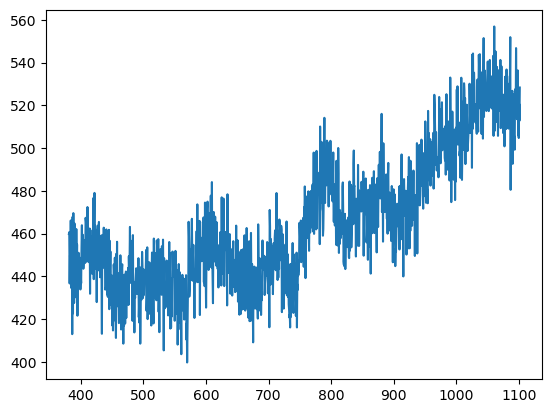

In [9]:
test_timestamp, test = spec.measure()
plt.figure(1)
spec.plot_data(wavelength, test)


In [10]:
print(wavelength[1264], len(wavelength))

1101.4334716796875 1265


In [11]:
# Set integration time to have ref spectrum peak about 50,000 to 60,000
spec.set_int_time(measconfig, 0.05)

In [12]:
for i in range(1, 27, 1):
    spec.set_scan_aves(measconfig, i*10)
    a, b, c, d = spec.measure_timing(measconfig)
    print(f"Timestamp: {a}, Ave Scans: {i*10}, transfer time = {c:.4g} ms, T_dif {d*1000:.4g} ms")

Timestamp: 2608913, Ave Scans: 10, transfer time = 7.45 ms, T_dif 7.95 ms
Timestamp: 2611015, Ave Scans: 20, transfer time = 9.971 ms, T_dif 10.97 ms
Timestamp: 2613703, Ave Scans: 30, transfer time = 13.46 ms, T_dif 14.96 ms
Timestamp: 2617300, Ave Scans: 40, transfer time = 17.91 ms, T_dif 19.91 ms
Timestamp: 2621767, Ave Scans: 50, transfer time = 21.44 ms, T_dif 23.94 ms
Timestamp: 2626952, Ave Scans: 60, transfer time = 23.93 ms, T_dif 26.93 ms
Timestamp: 2632751, Ave Scans: 70, transfer time = 28.4 ms, T_dif 31.9 ms
Timestamp: 2639617, Ave Scans: 80, transfer time = 30.91 ms, T_dif 34.91 ms
Timestamp: 2647198, Ave Scans: 90, transfer time = 34.4 ms, T_dif 38.9 ms
Timestamp: 2655495, Ave Scans: 100, transfer time = 38.87 ms, T_dif 43.87 ms
Timestamp: 2664655, Ave Scans: 110, transfer time = 42.38 ms, T_dif 47.88 ms
Timestamp: 2674727, Ave Scans: 120, transfer time = 44.87 ms, T_dif 50.87 ms
Timestamp: 2685507, Ave Scans: 130, transfer time = 47.36 ms, T_dif 53.86 ms
Timestamp: 269

In [13]:
# Set scans to be less than the delta time for the Gamry
# 200 scans to average should give a delta t of about 78-80 ms
# which is good when trying for 100 ms times between spectra
spec.set_scan_aves(measconfig, 200)

In [14]:
# Set integration time to have ref spectrum peak about 50,000 to 60,000
spec.set_int_time(measconfig, 0.05)

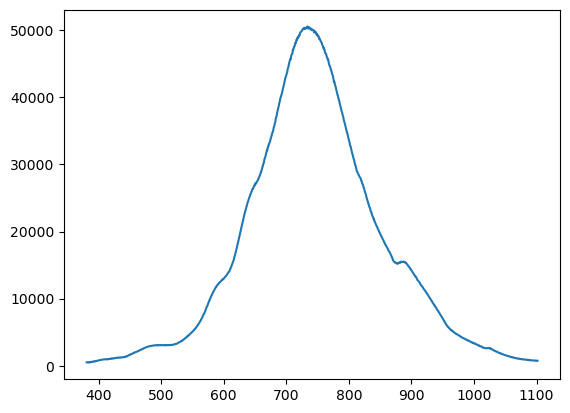

In [15]:
#   * updated 20250702

timestamp, test = spec.measure()
spec.plot_data(wavelength, test)

## Start here for the beginning of a run

## Set up integration time!
#Change int. time to get reference spectra in the range of 50,000 to 60,000.
#Use a similar glass 1 cm cell with water and blank FTO.

In [16]:
# Set integration time to have ref spectrum peak about 50,000 to 60,000
spec.set_int_time(measconfig, 0.05)

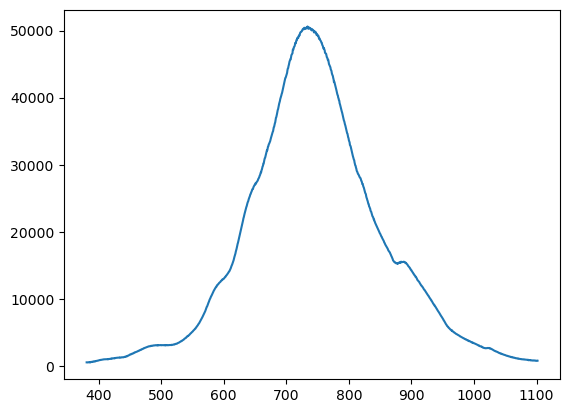

In [17]:
test_timestamp, test = spec.measure()
spec.plot_data(wavelength[0:2048], test[0:2048])

## Set up scans to average!
Run the following test to see how many scans you want to average.
Typically, 200 scans is good for 100ms average time between spectra.

In [18]:
for i in range(1, 27, 1):
    spec.set_scan_aves(measconfig, i*10)
    a, b, c, d = spec.measure_timing(measconfig)
    print(f"Timestamp: {a}, Ave Scans: {i*10}, transfer time = {c:.4g} ms, T_dif {d*1000:.4g} ms")

Timestamp: 4492386, Ave Scans: 10, transfer time = 6.514 ms, T_dif 7.014 ms
Timestamp: 4494264, Ave Scans: 20, transfer time = 10.97 ms, T_dif 11.97 ms
Timestamp: 4497062, Ave Scans: 30, transfer time = 14.46 ms, T_dif 15.96 ms
Timestamp: 4500753, Ave Scans: 40, transfer time = 17.95 ms, T_dif 19.95 ms
Timestamp: 4505149, Ave Scans: 50, transfer time = 21.4 ms, T_dif 23.9 ms
Timestamp: 4510424, Ave Scans: 60, transfer time = 25.92 ms, T_dif 28.92 ms
Timestamp: 4516622, Ave Scans: 70, transfer time = 28.41 ms, T_dif 31.91 ms
Timestamp: 4523385, Ave Scans: 80, transfer time = 30.91 ms, T_dif 34.91 ms
Timestamp: 4530961, Ave Scans: 90, transfer time = 34.4 ms, T_dif 38.9 ms
Timestamp: 4539244, Ave Scans: 100, transfer time = 37.89 ms, T_dif 42.89 ms
Timestamp: 4548317, Ave Scans: 110, transfer time = 41.37 ms, T_dif 46.87 ms
Timestamp: 4558204, Ave Scans: 120, transfer time = 45.86 ms, T_dif 51.86 ms
Timestamp: 4568979, Ave Scans: 130, transfer time = 48.35 ms, T_dif 54.85 ms
Timestamp: 4

In [19]:
# Set scans to be less than the delta time for the Gamry
# 200 scans to average should give a delta t of about 78-85 ms
spec.set_scan_aves(measconfig, 200)

## Take dark and reference spectra!
Block beam and take dark spectrum then put the glass cell with water and blank FTO in and take reference spectrum.

In [ ]:
# Background for use of setup for dark and ref spectra
#
# Don't run this cell
#
'''        
Args:
    wavelength: Wavelength array for plotting
    skip_dark (bool): If True, skip dark spectrum collection
    save_spectra (bool): If True, save collected spectra to files
    load_existing (bool): If True, attempt to load existing spectra instead of collecting
    data_dir (str): Directory to save/load spectra files
    file_prefix (str): Prefix for saved files (useful for different experiments)
    
    # Basic usage - collect new spectra and save them
    # dark, ref = setup(wavelength)
    
    # Skip dark and save with custom prefix
    # dark, ref = setup(wavelength, skip_dark=True, file_prefix="experiment_1")
    
    # Load existing spectra
    # dark, ref = setup(wavelength, load_existing=True)
    
    # Collect new spectra without saving
    # dark, ref = setup(wavelength, save_spectra=False)
    
    # Collect only new reference spectrum, preserving existing dark
    # dark, ref = setup(wavelength, collect_ref_only=True)
    
    # Collect only new dark spectrum, preserving existing reference
    # dark, ref = setup(wavelength, collect_dark_only=True)
    
    # List all saved spectra
    # list_saved_spectra()
    
    # Clean up old files
    # cleanup_old_spectra(days_old=30)
    
    # Load only a new dark spectrum, keep existing reference
    # dark, ref = setup(wavelength, load_existing=True, load_dark_only=True, existing_ref=current_ref)
    
    # Load only a new reference spectrum, keep existing dark
    # dark, ref = setup(wavelength, load_existing=True, load_ref_only=True, existing_dark=current_dark)
    
    # Collect new dark only, preserve existing reference
    # dark, ref = setup(wavelength, load_ref_only=True, existing_ref=current_ref)
    
    # Collect new reference only, preserve existing dark
    # dark, ref = setup(wavelength, load_dark_only=True, existing_dark=current_dark)
     
    
'''

# Basic usage - collect and save new spectra
dark, ref = setup(wavelength)

# Skip dark spectrum, save with experiment prefix
dark, ref = setup(wavelength, skip_dark=True, file_prefix="experiment_1")

# Load existing spectra instead of collecting new ones
dark, ref = setup(wavelength, load_existing=True)

# Collect new spectra without saving
dark, ref = setup(wavelength, save_spectra=False)

# Collect only new reference spectrum, preserving existing dark
dark, ref = setup(wavelength, collect_ref_only=True)

# Collect only new dark spectrum, preserving existing reference
dark, ref = setup(wavelength, collect_dark_only=True)

# List all saved spectra files
list_saved_spectra()

# Clean up files older than 30 days
cleanup_old_spectra(days_old=30)


DARK SPECTRUM COLLECTION
Hit ENTER to collect Dark Spectrum: 


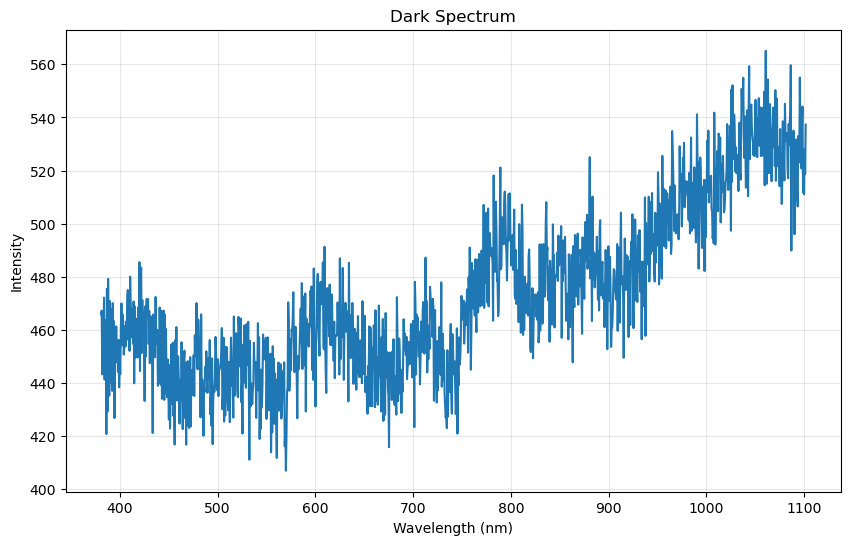

Dark spectrum saved to: spectra_data\20250721a_dark_20250723_141807.npz

REFERENCE SPECTRUM COLLECTION
Hit ENTER to collect Reference Spectrum: 


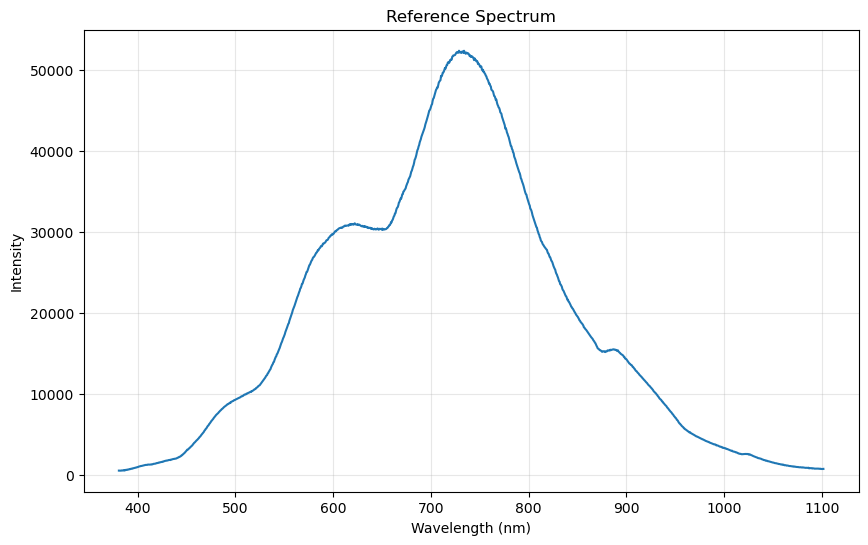

Reference spectrum saved to: spectra_data\20250721a_ref_20250723_141807.npz
Metadata saved to: spectra_data\20250721a_metadata_20250723_141807.json


In [22]:
dark, ref = setup(wavelength, file_prefix="20250721a")



Looking for existing spectra files...
Loading both dark and reference spectra...

Available both files:
1. 20250717a_20250717_095623.npz - Files: ['20250717a_dark_20250717_095623.npz', '20250717a_ref_20250717_095623.npz']
2. 20250717b_20250717_101337.npz - Files: ['20250717b_dark_20250717_101337.npz', '20250717b_ref_20250717_101337.npz']
3. 20250717c_20250717_120056.npz - Files: ['20250717c_dark_20250717_120056.npz', '20250717c_ref_20250717_120056.npz']
4. 20250717d_20250717_135658.npz - Files: ['20250717d_dark_20250717_135658.npz', '20250717d_ref_20250717_135658.npz']
5. 20250717d_20250717_145139.npz - Files: ['20250717d_dark_20250717_145139.npz', '20250717d_ref_20250717_145139.npz']
6. 20250721a_20250721_143753.npz - Files: ['20250721a_dark_20250721_143753.npz', '20250721a_ref_20250721_143753.npz']
7. 20250721a_20250722_142531.npz - Files: ['20250721a_dark_20250722_142531.npz', '20250721a_ref_20250722_142531.npz']
8. 20250721a_20250723_141807.npz - Files: ['20250721a_dark_20250723_14

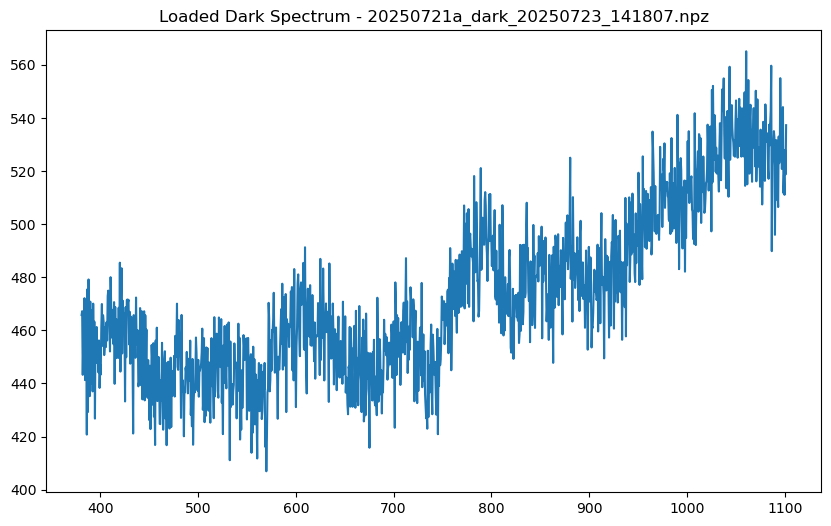

Loaded reference spectrum from: 20250721a_ref_20250723_141807.npz


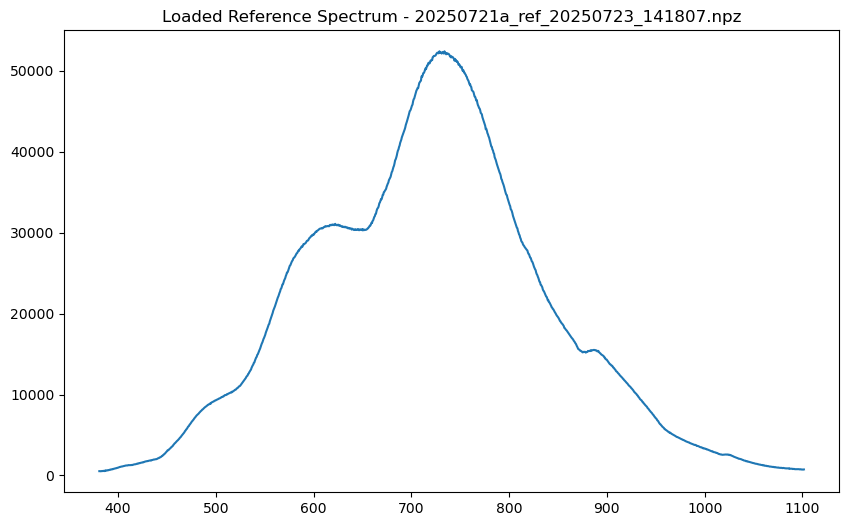

Successfully loaded spectra!


In [20]:
dark, ref = setup(wavelength, load_existing=True)

In [19]:
list_saved_spectra()


Saved spectra in 'spectra_data':
------------------------------------------------------------
File: 20250717a_dark_20250717_095623.npz
  Type: dark
  Timestamp: 704896338
  Modified: 2025-07-17 09:56:24
  Size: 1265 points

File: 20250717a_ref_20250717_095623.npz
  Type: reference
  Timestamp: 704989929
  Modified: 2025-07-17 09:56:25
  Size: 1265 points

File: 20250717b_dark_20250717_101337.npz
  Type: dark
  Timestamp: 808481765
  Modified: 2025-07-17 10:13:40
  Size: 1265 points

File: 20250717b_ref_20250717_101337.npz
  Type: reference
  Timestamp: 808621860
  Modified: 2025-07-17 10:13:41
  Size: 1265 points

File: 20250717c_dark_20250717_120056.npz
  Type: dark
  Timestamp: 1452199894
  Modified: 2025-07-17 12:00:57
  Size: 1265 points

File: 20250717c_ref_20250717_120056.npz
  Type: reference
  Timestamp: 1452304579
  Modified: 2025-07-17 12:00:58
  Size: 1265 points

File: 20250717d_dark_20250717_135658.npz
  Type: dark
  Timestamp: 2148417046
  Modified: 2025-07-17 13:56:59
 

In [23]:
# Use if needed
#cleanup_old_spectra(days_old=0)

Looking for existing spectra files...
Loading reference spectrum only (preserving existing dark)...

Available ref files:
1. 20250717a_ref_20250717_095623.npz
2. 20250717b_ref_20250717_101337.npz
3. 20250717c_ref_20250717_120056.npz
4. 20250717d_ref_20250717_135658.npz
5. 20250717d_ref_20250717_145139.npz
6. 20250721a_ref_20250721_143753.npz
7. dw__ref_20250717_104102.npz

Enter number to load existing ref spectrum/spectra, or 'n' for new: 6
Loaded reference spectrum from: 20250721a_ref_20250721_143753.npz
Preserving existing dark spectrum.


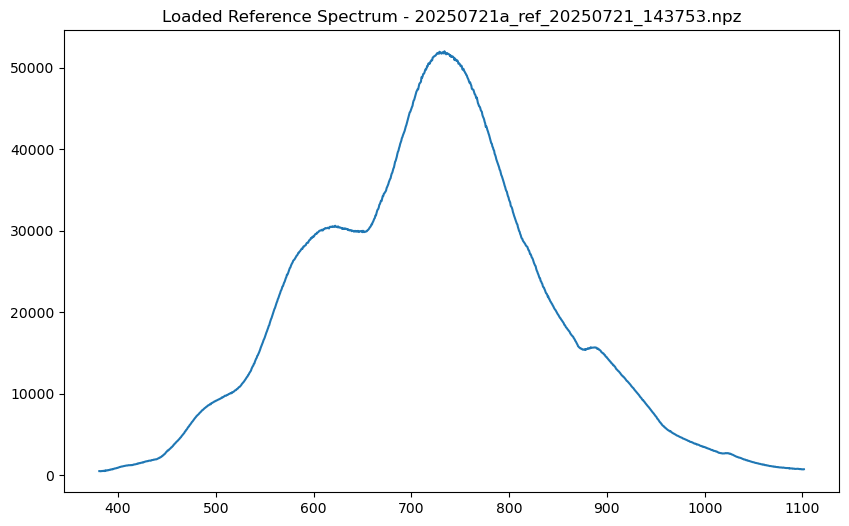

Successfully loaded spectra!


In [21]:
 dark, ref = setup(wavelength, load_existing=True, load_ref_only=True, existing_dark=dark)

In [49]:
type(dark)

numpy.ndarray

## Ready to take setup and take SpectroElectroChem Data!
Get the Gamry sequence wizard setup and then duplicate the settings below.

ENTER existing sample (format: 20211201_Description) data folder without separators: 20250723_P3HT9010rerun_KPF6
ENTER CV cycles):3
ENTER CV total voltage (V), [1 cycle e.g., 0->0.7->-0.5->0 = 2.4V]:2.4
ENTER CV step size (mV) [typical = 10.0 mV]:10
ENTER CV scan rate (mV/sec) [typical = 100 mV / sec]:100
ENTER Chrono run duration (s):60
ENTER Chrono run deta time (s):0.1
ENTER The total potentials for doping:8
Collect (n)ew dark and reference spectra or use old data (enter):
Hit ENTER to collect CV and ALL doping-dedoping spectra:

****
CV Spectra
*** Waiting for Gamry to start and collect all sequence data. ***

CV_delta_time:  0.1
Data Type:  1
num_echem_points:  721
Run number:  0
Run: 0 with datatype = 1 and Wavelength and spectrum lengths: 1265 points
* - echem run was triggered!
Total Time:  90.42640423774719 73.44251  and loops:  721 , Start =  1753310024.2034209 ,  Stop =  1753310114.629825
Start =  1753310024.2034209 ,  Stop =  1753310114.629825
Done with loops, wavelength po

Done with FUNCTION for spectra: Run Number:  4  Data Type =  3 

=========DONE WITH Spectra FUNCTION==========

Dedoping data4 Ploting Dedoped Spectra:
Done with dedoping for 4!




********
Doping:  5
Data Folder:  20250723_P3HT9010rerun_KPF6
Data Type:  2
num_echem_points:  601
Run number:  5
Run: 5 with datatype = 2 and Wavelength and spectrum lengths: 1265 points
* - echem run was triggered!
Total Time:  101.55647730827332 61.21652999999992  and loops:  601 , Start =  1753311460.9951046 ,  Stop =  1753311562.5515819
Start =  1753311460.9951046 ,  Stop =  1753311562.5515819
Done with loops, wavelength points: 1265 and spectrum points: 1265 
Done with FUNCTION for spectra: Run Number:  5  Data Type =  2 

=========DONE WITH Spectra FUNCTION==========

Doping data5 Ploting Doped Spectra:
Done with doping for 5!
===




*******
Dedoping:  5
Data Folder:  20250723_P3HT9010rerun_KPF6
Data Type:  3
num_echem_points:  601
Run number:  5
Run: 5 with datatype = 3 and Wavelength and spectrum 

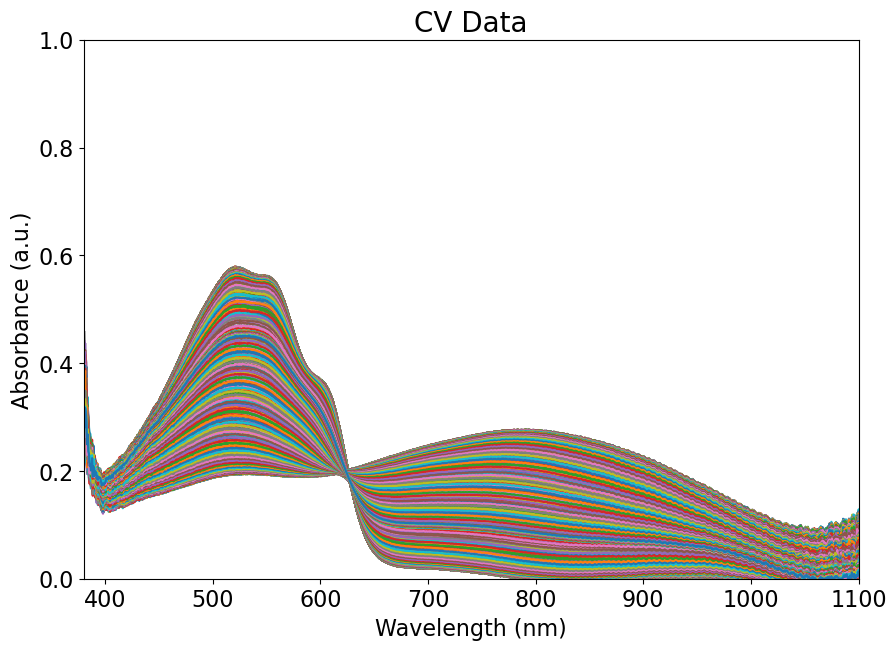

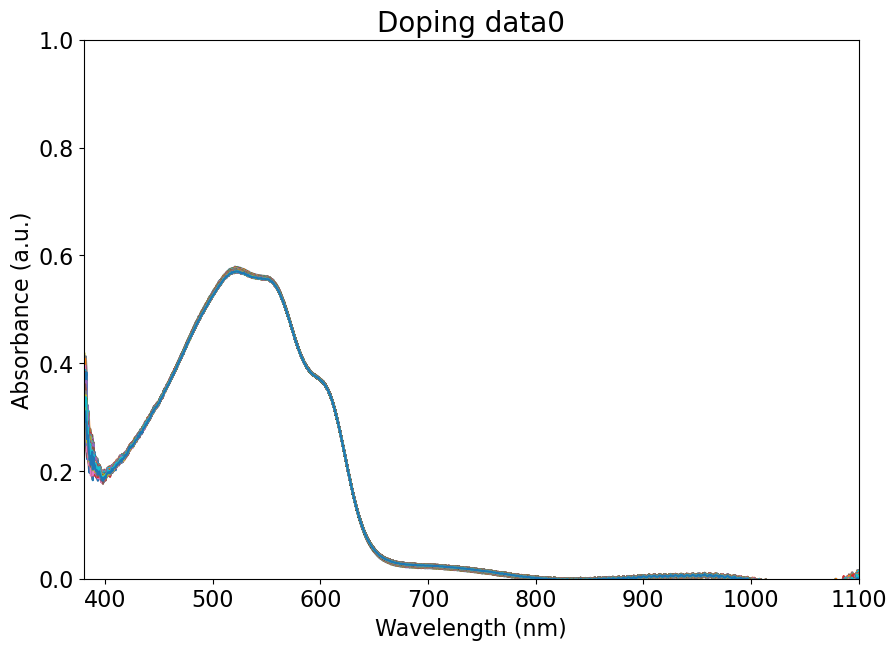

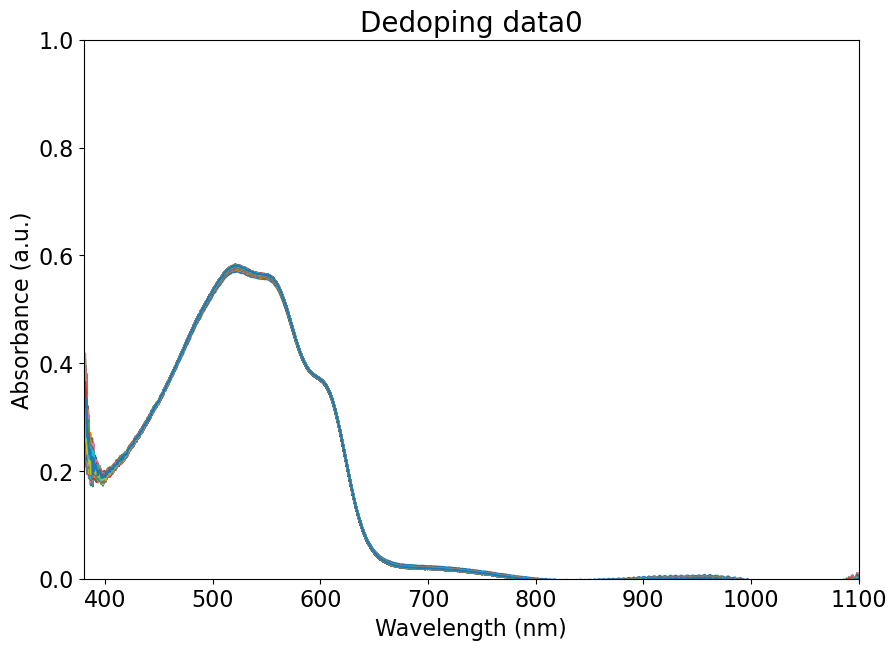

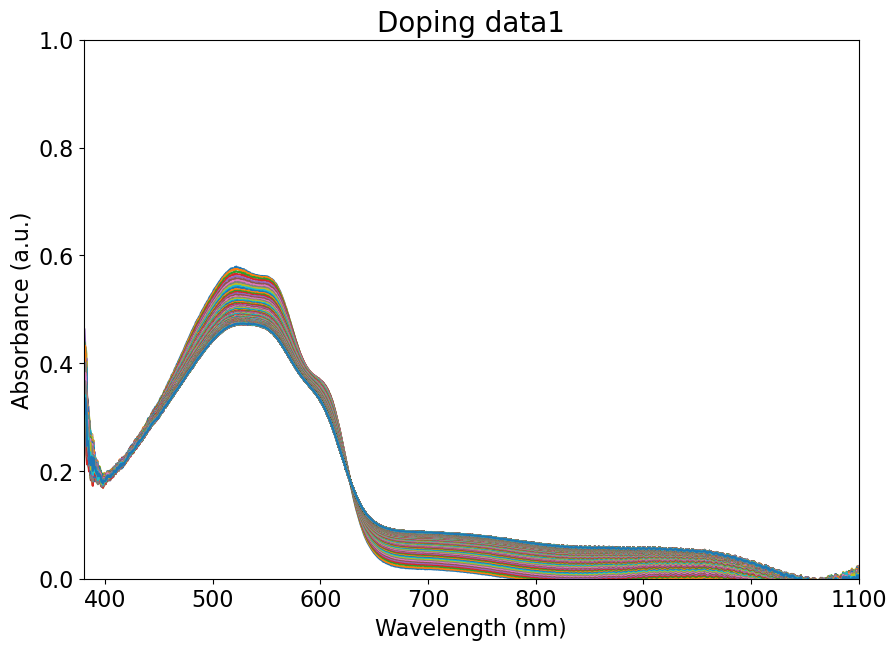

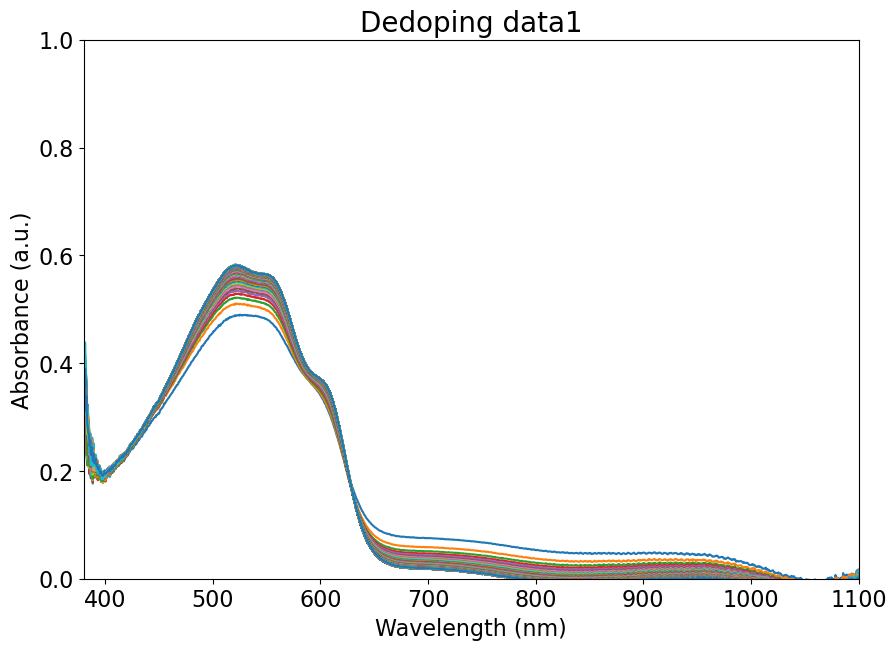

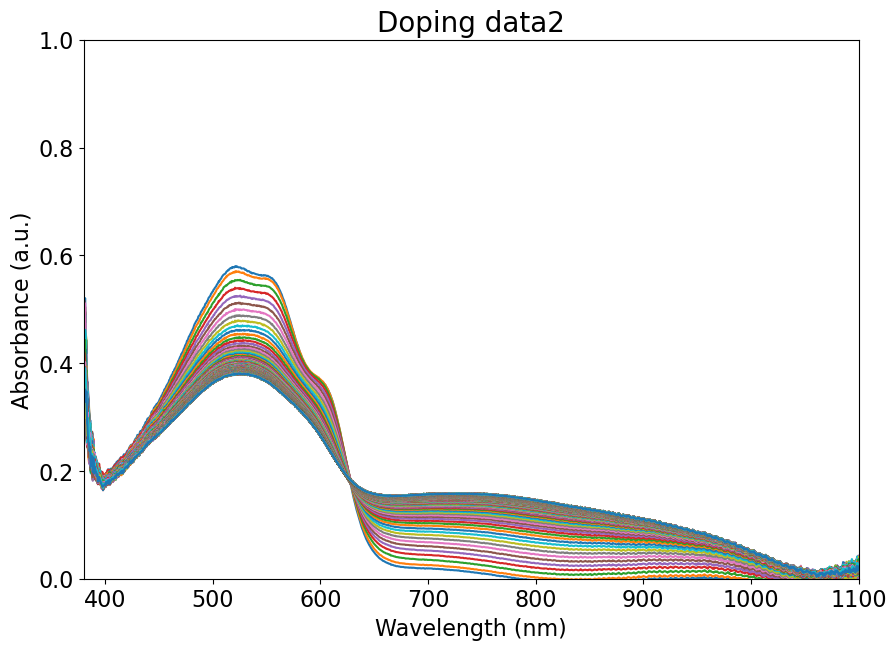

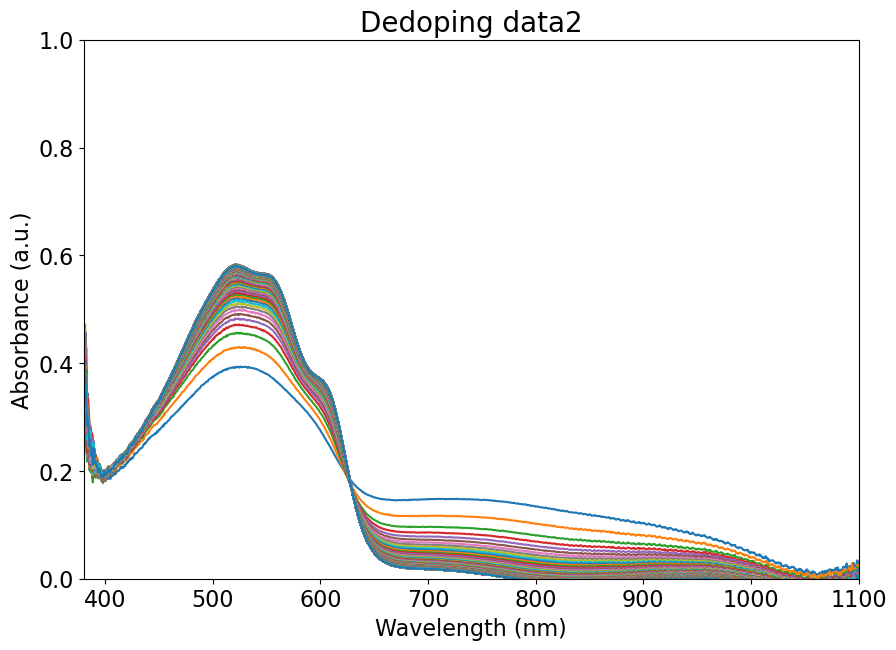

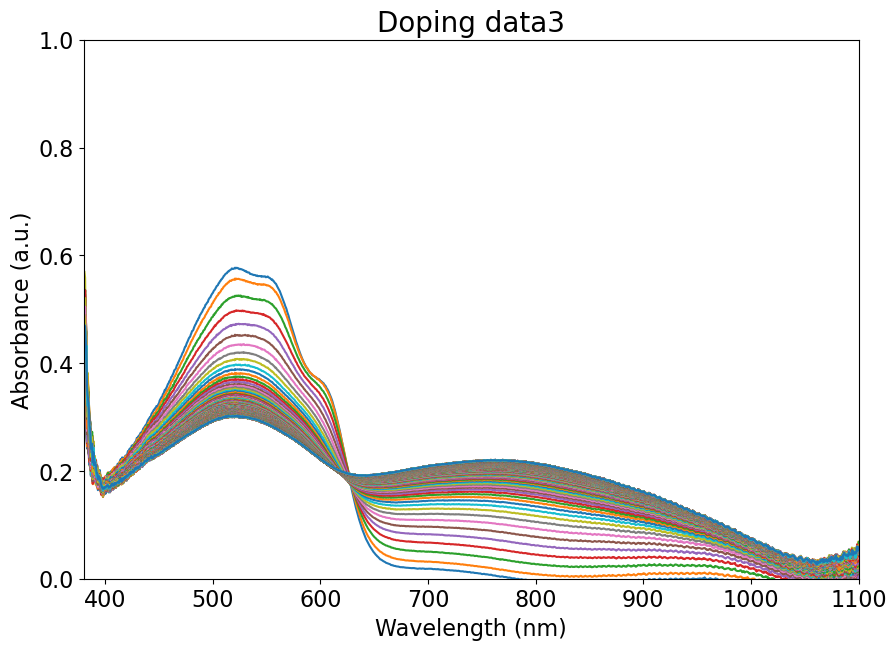

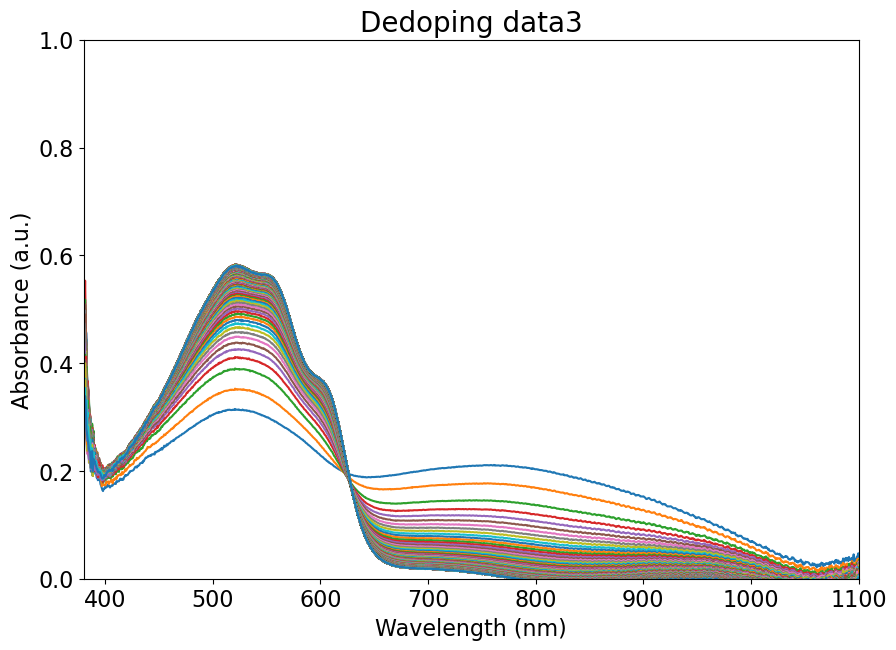

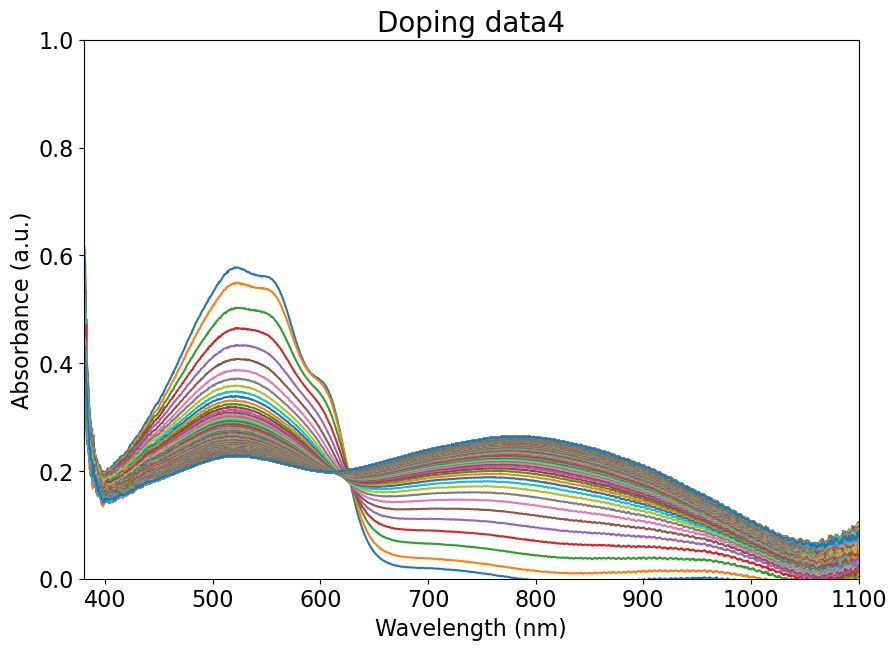

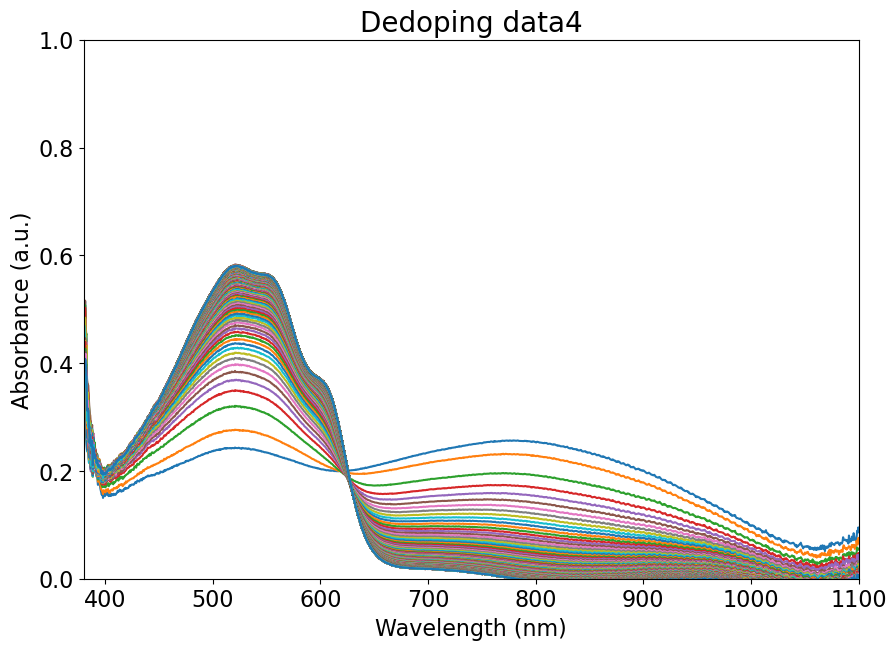

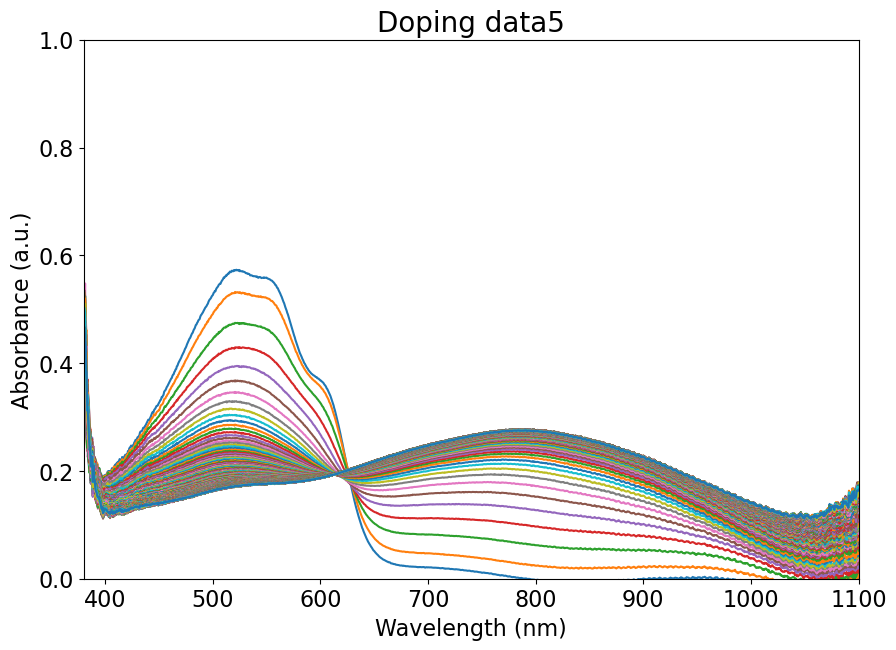

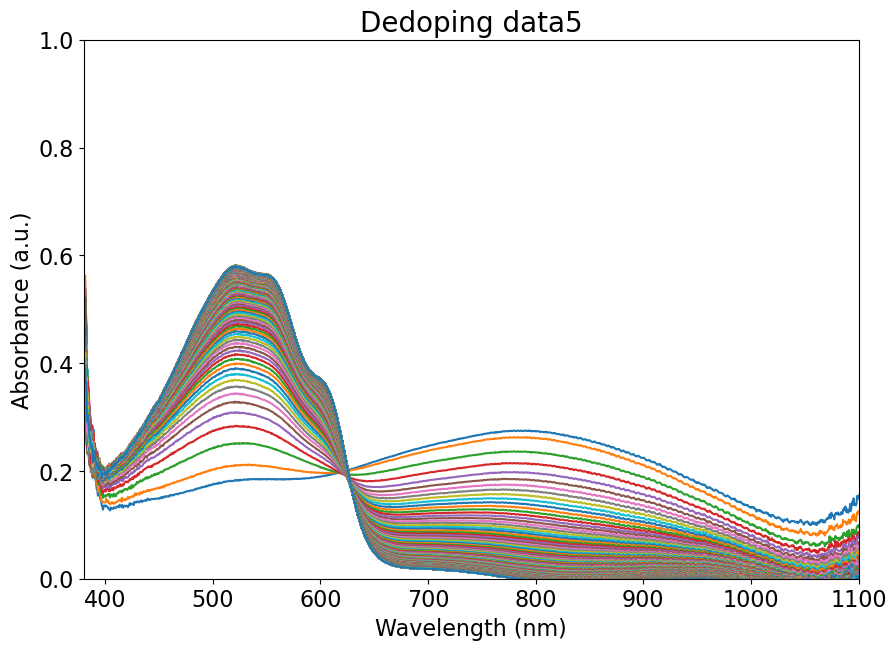

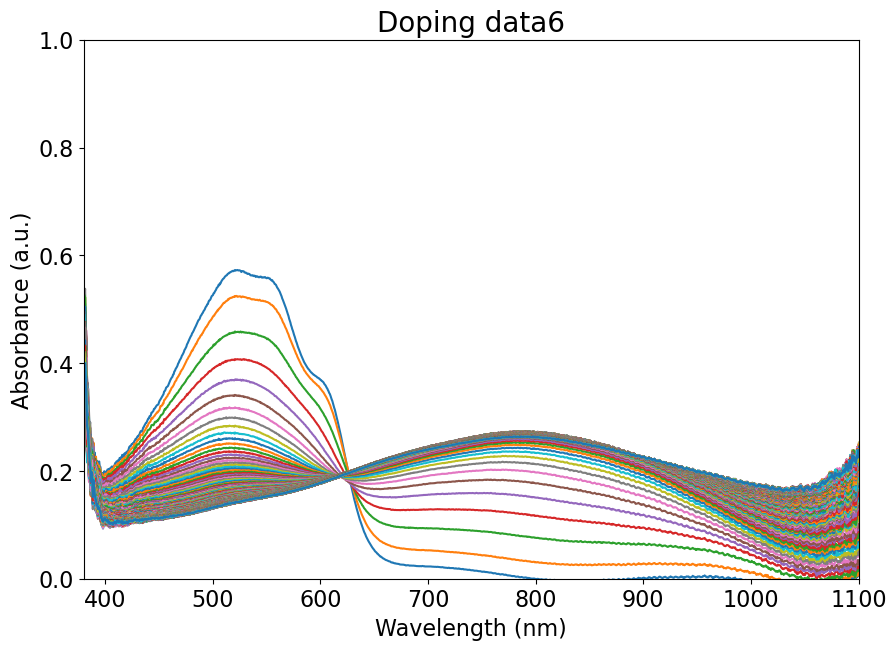

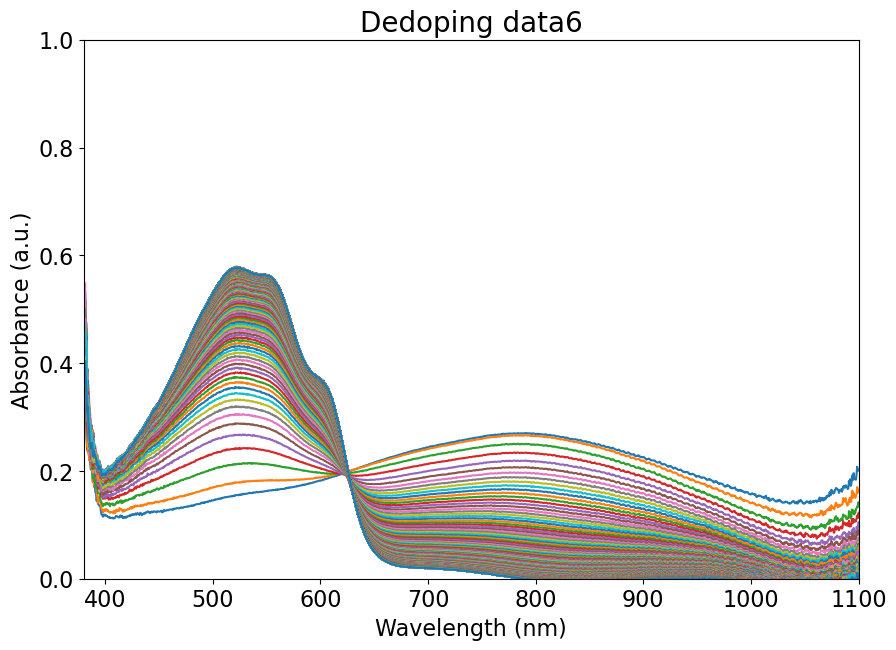

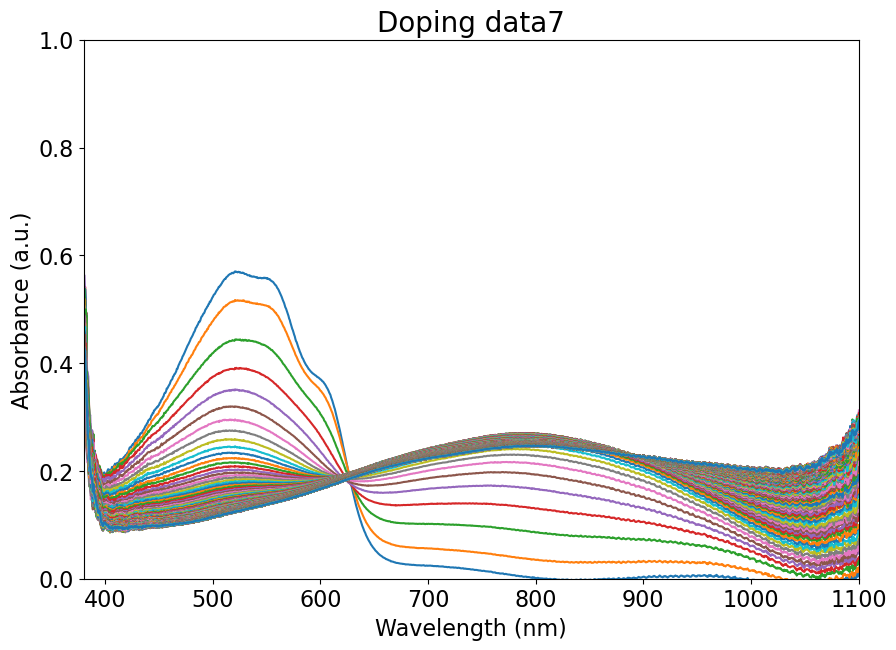

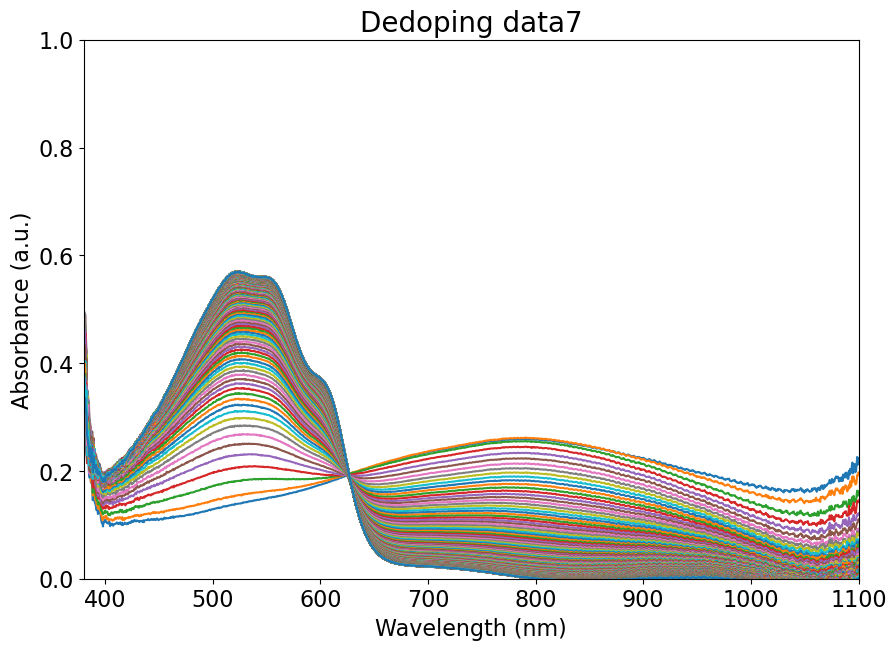

In [21]:
#---------------------------------------------------------------------------
# Sequence Wizard
# 20230619 Basic Acquistion for CV, dedope for X seconds, and THEN multiple cycles of doping / dedoping
#
#---------------------------------------------------------------------------
#
# Basic Spec E Chem acquisition setup
#
# Setup variables (base path: 'C:\Users\inst-chem\Documents')
#
# added_path, dark, ref, deltaTime = 0.100, num_echem_points = 301, data_type = 1, run_number = 0, trigger=False):
#
# ---> Default values
# 1) added_path = '' --> no separators
# 2) dark
# 3) ref
# 4) deltaTime = 0.100
# 5) num_echem_points = 101
# 6) data_type = 1
# 7) run_number=1
# 8) trigger=False
#goData = input("Hit ENTER to collect ONE triggered Echem Spectra")
data_folder = ''
#
# Loop limit with 16 gives about 100 ms +10% and at 24 give about 140 ms or +40%  
# (I still have not figured out where the extra 10 % is from???)
#
CV_cycles = 0
CV_total_voltage = 0 # V
CV_step_size = 0 # mV
CV_scan_rate = 0 # mV/sec
CV_delta_time = 0  # sec
Chrono_time = 0
Chrono_deltatime = 0
total_potentials = 0
trigger = True
debug = True

# Set variables if not set
if (data_folder == ''):
    data_folder = input("ENTER existing sample (format: 20211201_Description) data folder without separators: ")
if (CV_cycles == 0):
    CV_cycles_str = input("ENTER CV cycles):")
    CV_cycles = int(CV_cycles_str)
if (CV_total_voltage == 0):
    CV_total_voltage_str = input("ENTER CV total voltage (V), [1 cycle e.g., 0->0.7->-0.5->0 = 2.4V]:")
    CV_total_voltage = float(CV_total_voltage_str)
if (CV_step_size == 0):
    CV_step_size_str = input("ENTER CV step size (mV) [typical = 10.0 mV]:")
    CV_step_size = float(CV_step_size_str)
if (CV_scan_rate == 0):
    CV_scan_rate_str = input("ENTER CV scan rate (mV/sec) [typical = 100 mV / sec]:")
    CV_scan_rate = float(CV_scan_rate_str)
if (Chrono_time == 0):
    Chrono_time_str = input("ENTER Chrono run duration (s):")
    Chrono_time = float(Chrono_time_str)
if (Chrono_deltatime == 0):
    Chrono_deltatime_str = input("ENTER Chrono run deta time (s):")    
    Chrono_deltatime = float(Chrono_deltatime_str)
if (total_potentials == 0):
    total_potentials_str = input("ENTER The total potentials for doping:")    
    total_potentials = int(total_potentials_str)

#
# Get dark and reference spectra
#
goData = input("Collect (n)ew dark and reference spectra or use old data (enter):")
if goData == 'n':
    dark, ref = setup(wavelength, False)

#
# Data types:
#
# 1 == CVspectra.txt
# 2 == spectra(x).txt
# 3 == dedopingspectra(x).txt
# 4 == prededoping.txt
goData = input("Hit ENTER to collect CV and ALL doping-dedoping spectra:")
print ("\n****\nCV Spectra\n*** Waiting for Gamry to start and collect all sequence data. ***\n")
#
# Get CV data
# Data type == 1
data_type = 1
run_number = 0
num_echem_points = int(  CV_total_voltage/CV_step_size*1000*CV_cycles +1)
added_path = data_folder
CV_delta_time =  CV_step_size / CV_scan_rate
if (debug == True):
    print ("CV_delta_time: ",CV_delta_time)
    print ("Data Type: ",data_type)
    print ("num_echem_points: ",num_echem_points)
    print ("Run number: ",run_number)

cv_spectra, cv_absorbance = get_spectra(measconfig, data_folder, dark, ref, CV_delta_time, num_echem_points, data_type, run_number, trigger)
plot_data("CV Data",cv_absorbance)
print("Done with CV!\n")
#
# ADDED PRE dedoping spectra
#

#
# PRE - Dedoping spectra
#
print ("\n\n***\nPre Dedoping: ")
num_echem_points = int(Chrono_time/Chrono_deltatime+1)
data_type = 4
if (debug == True):
    print ("Data Folder: ", data_folder)
    print ("Data Type: ",data_type)
    print ("num_echem_points: ",num_echem_points)
    print ("Run number: ",run_number)
prededope_spectra, prededope_absorbance = get_spectra(measconfig, data_folder, dark, ref, Chrono_deltatime, num_echem_points, data_type, run_number, trigger)
print("Done with predoping!\n===\n\n")

# Don't save prededoping spectra...

#
# Get doping and dedoping spectra pairs for each doping potential
#     first get doping with datatype 2
#     second get dedoping with datatype 3
print ("Doping and dedoping runs of 0 to ", total_potentials-1)
print ("---------------------------------")
#Switching back to range(total_potentials) NOT +1
for run_number in range(total_potentials):
    #
    # Doping
    #
    print ("\n\n********")
    print ("Doping: ", run_number)
    data_type = 2
    num_echem_points = int(Chrono_time/Chrono_deltatime+1)
    if (debug == True):
        print ("Data Folder: ", data_folder)
        print ("Data Type: ",data_type)
        print ("num_echem_points: ",num_echem_points)
        print ("Run number: ",run_number)
    dope_spectra, dope_absorbance = get_spectra(measconfig, data_folder, dark, ref, Chrono_deltatime, num_echem_points, data_type, run_number, trigger)
    print(f"Doping data{run_number}", "Ploting Doped Spectra:")
    plot_data(f"Doping data{run_number}", dope_absorbance)
    print(f"Done with doping for {run_number}!\n===\n\n")
    #
    # Dedoping spectra
    #
    print ("\n\n*******\nDedoping: ", run_number)
    data_type = 3
    if (debug == True):
        print ("Data Folder: ", data_folder)
        print ("Data Type: ",data_type)
        print ("num_echem_points: ",num_echem_points)
        print ("Run number: ",run_number)
    dedope_spectra, dedope_absorbance = get_spectra(measconfig, data_folder, dark, ref, Chrono_deltatime, num_echem_points, data_type, run_number, trigger)
    print(f"Dedoping data{run_number}","Ploting Dedoped Spectra:")
    plot_data(f"Dedoping data{run_number}", dedope_absorbance)
    print(f"Done with dedoping for {run_number}!\n=======\n\n")


## Misc. Cells !
Various code for certain potentially useful things to do.

In [ ]:
# data_folder = '20211115_test1'
num_echem_points = 101
data_type = 3
run_number = 8
trigger = False
spectra_data, absorb_data = get_spectra(measconfig, data_folder,dark, ref, num_echem_points, data_type, run_number, trigger)



In [ ]:
plot_data(absorb_data)

In [ ]:
#
# Save Data in UW / Spec E Chem format
#

# Build Output file

# Build spectra DF of raw values
spectra_df = pd.DataFrame(spectra).T

for time_point in range(num_echem_points):
    #print ("output time point: ", time_point)
    
    # add wavelengths all time
    output_df = pd.DataFrame(wavelengths)

    # add absorbances and change per time value
    append_df = absorb7.iloc[0:,time_point].values
    output_df.insert(1, "0", append_df) 

    # Add dark curve only first time
    if time_point == 0:        
        append_df = pd.DataFrame(dark)
        output_df = pd.concat([output_df,append_df], axis=1) 
    else:
        append_df = pd.DataFrame(np.empty(0, dtype=float))
        output_df = pd.concat([output_df,append_df], axis=1) 

    # Add 100% data only first time
    if time_point == 0:        
        append_df = pd.DataFrame(ref)
        output_df = pd.concat([output_df,append_df], axis=1) 
    else:
        append_df = pd.DataFrame(np.empty(0, dtype=float))
        output_df = pd.concat([output_df,append_df], axis=1) 

    # Add raw spectral data
    append_df = spectra_df.iloc[0:,time_point].values
    append_df
    output_df.insert(4, "1", append_df) 

    # Setup index column
    index_list =[]
    numbers = range(time_point*2048+1,time_point*2048+2049)
    #print (numbers)
    for number in numbers:
        index_list.append(number)
    index_df = pd.Series(index_list)
    
    # Add index all times.
    append_df = pd.DataFrame(index_df.values)
    output_df = pd.concat([output_df,append_df], axis=1) 
    # Make the values ints
    output_df.iloc[:,5:] = output_df.iloc[:,5:].fillna(0.0).astype(int)
    
    # Add Spectrum number per spectrum
    # - COMMENT Out for index
    #
    output_df.iloc[:,5:] = time_point+1
    
    # Add absolute time in whole column
    time_list =[]
    numbers = range(1,2049)
    time_value = timeStamp_diff[time_point]
    for number in numbers:
        time_list.append(time_value)
    time_df = pd.Series(time_list)
    append_df = pd.DataFrame(time_df.values)
    output_df = pd.concat([output_df,append_df], axis=1) 

    # Add relative time in whole column
    time_list =[]
    numbers = range(1,2049)
    time_value = timeStamp_diff[time_point] - timeStamp_diff[0]
    for number in numbers:
        time_list.append(time_value)
    time_df = pd.Series(time_list)
    append_df = pd.DataFrame(time_df.values)
    output_df = pd.concat([output_df,append_df], axis=1) 
#    output_df.to_csv(r'c:\Users\inst-chem\Downloads\output_df.csv', header=False, index=False, mode = 'a', sep ='\t')
    if time_point == 0:
        output_df_all = output_df
    else:
        output_df_all = pd.concat([output_df_all,output_df], axis=0, ignore_index=True) 

#
# Set up Column Headings for some relevant label
#

#
# For spectra(X).txt files (doping) (MUST FIX INDEX to be SPECTRUM NUMBER)
#
output_df_all.columns = ['Wavelength (nm)','Absorbance','Column 3 (a. u.)','Column 4 (a. u.)','Measured value (a.u.)','Spectrum number', 'Time (s)', 'Corrected time (s)']

#
# For dedopingspectra(X).txt files (dedoping)
#
#output_df_all.columns = ['Wavelength (nm)','Absorbance','Column 3 (a. u.)','Column 4 (a. u.)','Measured value (a.u.)','Index', 'Time (s)', 'Corrected time (s)']

#
# Write out file
#
output_df_all.to_csv(r'c:\Users\inst-chem\Downloads\output_df_all.csv', header=True, index=False, sep ='\t')

#print (output_df_all.shape)
#print (output_df.shape)
#output_df_all

In [ ]:
output_df_all


In [ ]:
output_df_all.to_csv(r'c:\Users\inst-chem\Downloads\20211104a.txt', header=True, index=False, sep ='\t')


In [ ]:
#
# Example of how to save data without header or index
#

#absorb7_DW1 = absorb7.iloc[0:,1]
# Following saves without index or header and in append mode
#absorb7_DW1.to_csv(r'c:\Users\inst-chem\Downloads\aborb7_DW1.csv', header=False, index=False, mode = 'a')


In [ ]:
#
# Plot doping and dedoping plots
#
# • Will need to split this into two files... dope and dedoping.
#

absorb7_dope = absorb7.iloc[:,11:60:10]
absorb7_dope

pp = absorb7_dope.plot(legend=False,  figsize = (10,7), fontsize = 16, title ='Pandas Plot')

pp.set_xlabel('Wavelength (nm)', fontsize = 16)
pp.set_ylabel('Absorbance (a.u.)', fontsize = 16)
pp.set_title('P3HT with NaCl, Dope, every sec.', fontsize = 20)


pp.set_xlim(400,1000)
#pp.set_ylim(0,1)


absorb7_dedope = absorb7.iloc[:,60::10]
absorb7_dedope

pp = absorb7_dedope.plot(legend=False,  figsize = (10,7), fontsize = 16, title ='Pandas Plot')

pp.set_xlabel('Wavelength (nm)', fontsize = 16)
pp.set_ylabel('Absorbance (a.u.)', fontsize = 16)
pp.set_title('P3HT with NaCl, Dedope, every sec.', fontsize = 20)


pp.set_xlim(400,1000)
#pp.set_ylim(0,1)


In [ ]:
#
# Plotting Abs at a wavelength vs time for dope and dedoped data
#

# Choose wavelength
absorb8_dope = absorb7.loc[582.2:582.5,0.9:7.5]
#absorb8_dope

#timeStamp_df = pd.DataFrame(timeStamp_diff)

#timeStamp_df.shape

#timeStamp_df.T
#print(absorb8_dope.T.head(20))
#print(absorb8_dope.T.index.values)
plt.figure(figsize = (16,9))

plt.xlabel('Time (sec)', fontsize = 16)
plt.ylabel('Absorbance (a.u.)', fontsize = 16)
plt.title('P3HT with NaCl, Dope, 562 nm', fontsize = 20)


plt.plot(absorb8_dope.T.index.values, absorb8_dope.T) 


#pp = absorb7_dope.plot(x=wavelengths, y=absorb8_dope, legend=False,  figsize = (10,7), fontsize = 16, title ='Pandas Plot')



plt.figure(figsize = (16,9))


absorb8_dope = absorb7.loc[562.2:562.5,7.6:13]
#absorb8_dope

#timeStamp_df = pd.DataFrame(timeStamp_diff)

#timeStamp_df.shape

#timeStamp_df.T
#print(absorb8_dope.T.head(20))
#print(absorb8_dope.T.index.values)

plt.xlabel('Time (sec)', fontsize = 16)
plt.ylabel('Absorbance (a.u.)', fontsize = 16)
plt.title('P3HT with NaCl, Dedope, 562 nm', fontsize = 20)


plt.plot(absorb8_dope.T.index.values, absorb8_dope.T) 



In [ ]:
#
# Options for saving dataframe only
#

#absorb7.to_hdf(r'c:\Users\inst-chem\Downloads\aborb7_sm_data.h5', key='df', mode='w')
#absorb7.to_csv(r'c:\Users\inst-chem\Downloads\aborb7_sm_data.csv', sep ='\t')
#absorb7.shape
#absorb7

In [ ]:
absorb3_df

In [ ]:
absorb4

In [ ]:
absorb5

In [ ]:
absorb6

In [ ]:
absorb7

In [ ]:
# Set integration time to have ref spectrum peak about 50,000 to 60,000
spec.set_int_time(measconfig, 0.05)

In [ ]:
# Set scans to be less than the delta time for the Gamry
# 200 scans to average should give a delta t of about 78-80 ms
spec.set_scan_aves(measconfig, 150)

In [ ]:
# ------------
#
#  Make into data acquistion function
#
# • Figure out where to see all of these constants that will depend on echem settings.
# * Working version DW 20250708
# * Test code for timing and data acquistition
#

num_echem_points = 10 # Total seconds at 0.1 s deltas --> num+echem_points * deltaTime
deltaTime = 0.1 # seconds

#
# Get wavelengths
#
wavelength_old, wavelength = spec.wavelengths()
wavelengths3 = wavelength[24:2000]
goData = input("Hit ENTER to collect ONE triggered Echem Spectra")


# absolute timestamp from Varius
timeStamp = []
# time since tail end of first spectrum
timeStamp0 = []
# difference between all points hence n-1 times from zero
timeStamp1 = []
pre_check = []


# use later
spectra = []
j=0
# for testing:
trigger_mode = 0
spec.set_trig_mode(measconfig, trigger_mode)

#while j <  num_echem_points:
# NOTE: Use time in seconds
for j in range(0, num_echem_points): 
    if (j == 0):
        start = time.time_ns()/1e9 # put in seconds
        pretime1 = start
        timestampAV, data0 = spec.measure()
        pretime = timezero = timestampAV/1e5 # put in seconds
        past = pretime
        spec.set_trig_mode(measconfig, 0)
        timeStamp.append(pretime)
        print (f"* - echem run was triggered!")

    elif (j != 0):
        pretime1 = time.time_ns()/1e9  # put in seconds
        timestampAV, data0 = spec.measure()
        pretime = timestampAV/1e5  # put in seconds
        timeStamp.append(pretime)
    time.sleep(0.002)
    check_time = time.time_ns()/1e9 # put in seconds
    while ((check_time-pretime1) <= (deltaTime-0.0012)):
        check_time = time.time_ns()/1e9 # put in seconds
        time.sleep(0.5e-3) # sleep for 0.5 ms

    diff = (pretime - timezero)
    diff1 = (pretime - past) 

    past = pretime

    if (j>0):
        timeStamp0.append(diff)
        timeStamp1.append(diff1)

    spectra.append(data0)

            
stop = time.time_ns()/1e9
total = (stop - start) 
wait_time = timeStamp[num_echem_points-1] - timeStamp[0]
pretotal = (stop - pretime1)/1e9
print ("Total Time: ",total, wait_time," and loops: ", j+1, ", Start = ", start, ",  Stop = ", stop)
print ("Start = ", start, ",  Stop = ", stop)

print ("Done with loops")    
data4a = data0[24:2000] 
plt.plot(wavelengths3,data4a) 
plt.show()

plt.figure(1)
plt.plot(timeStamp1,'.', color='blue')
plt.show

plt.figure(2)
plt.plot(timeStamp0,'.', color='blue')
plt.show



In [ ]:
total_time = timeStamp[9] - timeStamp[0]
print(f"Total time from Varius: {total_time}, and point 0 and 50 are: {timeStamp[0], timeStamp[9]}")

In [ ]:
len(timeStamp)

In [ ]:
steps = len(timeStamp)
for x in range(0,num_echem_points-1):
    print ((timeStamp[x]-timeStamp[0]))


In [ ]:
steps = len(timeStamp)
for x in range(0,num_echem_points-1):
    print ((timeStamp[x+1]-timeStamp[x]))


In [ ]:
type(dark)


### The following is cleaned up by ChatGPT.
Date: July 14, 2025:  I suspect there are many good points but also need to validate the output.

In [ ]:
"""
Main module for cyclic voltammetry (CV) and doping/dedoping spectra acquisition.

This script handles user input for experiment parameters, controls the measurement
sequence, collects spectra using an external spectrometer interface, and manages
data plotting and saving.

Functions:
----------
- get_user_value(prompt, value_type=float, default=None)
    Prompts the user for input, validates and converts it to the specified type.

- collect_dark_reference()
    Handles user decision to collect new dark/reference spectra or reuse existing data.

- collect_spectra_sequence()
    Main acquisition loop:
    - Collects CV spectra.
    - Collects pre-dedoping spectra.
    - Iteratively collects doping and dedoping spectra for all specified potentials.
    Uses the `get_spectra()` function (assumed to be defined elsewhere) for data acquisition.

Usage:
------
Run the script standalone to execute the full sequence after providing requested inputs.
Ensure required spectrometer configuration (`measconfig`) and functions (`setup()`, `get_spectra()`, `plot_data()`) are available.

Logging:
--------
Uses Python's logging module for informational and debug messages to track progress.

Notes:
------
- Assumes all spectrometer and plotting dependencies are properly configured externally.
- Timing and data collection parameters are user-defined for flexibility.
"""

import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def get_user_value(prompt, value_type=float, default=None):
    """
    Prompt user for input and convert it to the specified type.

    Parameters:
    -----------
    prompt : str
        Text prompt to display to the user.
    value_type : type, optional (default=float)
        Data type to convert input into (e.g., int, float).
    default : optional
        Default value returned if user inputs nothing.

    Returns:
    --------
    value : value_type
        User input converted to specified type, or default if input is empty.
    """
    while True:
        try:
            value_str = input(prompt)
            if not value_str and default is not None:
                return default
            return value_type(value_str)
        except ValueError:
            print("Invalid input. Please try again.")

def collect_dark_reference():
    """
    Prompt user whether to collect new dark and reference spectra or use existing data.

    Returns:
    --------
    dark, ref : tuple or (None, None)
        Collected dark and reference spectra if new data requested; otherwise None.
    """
    if input("Collect (n)ew dark and reference spectra or use old data (enter):") == 'n':
        return setup()
    return None, None

def collect_spectra_sequence():
    """
    Orchestrates full data acquisition sequence.

    Steps:
    ------
    1. Collects or reuses dark/reference spectra.
    2. Collects cyclic voltammetry (CV) spectra.
    3. Collects pre-dedoping spectra.
    4. Iteratively collects doping and dedoping spectra for each doping potential.

    Uses:
    -----
    - get_spectra() for spectral acquisition (external function).
    - plot_data() for visualization (external function).
    - User input parameters collected at start of script.

    Side Effects:
    -------------
    - Plots data after each acquisition phase.
    - Saves collected data files (handled inside get_spectra).
    """
    dark, ref = collect_dark_reference()
    input("Hit ENTER to collect CV and ALL doping-dedoping spectra:")

    logging.info("Starting CV Spectra collection...")
    data_type = 1
    run_number = 0
    num_echem_points = int(CV_total_voltage / CV_step_size * 1000 * CV_cycles + 1)
    CV_delta_time = CV_step_size / CV_scan_rate

    logging.debug(f"CV_delta_time: {CV_delta_time}")
    logging.debug(f"num_echem_points: {num_echem_points}")

    cv_spectra, cv_absorbance = get_spectra(measconfig, data_folder, dark, ref, CV_delta_time, num_echem_points, data_type, run_number, trigger=True)
    plot_data("CV Data", cv_absorbance)
    logging.info("Done with CV!")

    logging.info("Starting Pre-Dedoping Spectra collection...")
    num_echem_points = int(Chrono_time / Chrono_deltatime + 1)
    data_type = 4
    prededope_spectra, prededope_absorbance = get_spectra(measconfig, data_folder, dark, ref, Chrono_deltatime, num_echem_points, data_type, run_number, trigger=True)
    logging.info("Done with Pre-Dedoping.")

    for run_number in range(total_potentials):
        for dtype, action in [(2, "Doping"), (3, "Dedoping")]:
            logging.info(f"{action} run {run_number}")
            num_echem_points = int(Chrono_time / Chrono_deltatime + 1)
            spectra, absorbance = get_spectra(measconfig, data_folder, dark, ref, Chrono_deltatime, num_echem_points, dtype, run_number, trigger=True)
            plot_data(f"{action} data {run_number}", absorbance)
            logging.info(f"Done with {action} for run {run_number}")

if __name__ == "__main__":
    collect_spectra_sequence()





In [46]:
import logging
import time
import numpy as np
import pandas as pd
from pathlib import Path

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def get_spectra(measconfig, added_path, dark, ref, delta_time=0.100, num_echem_points=301, data_type=1, run_number=0, trigger=False):
    """
    Acquire spectroscopic data from the measurement setup and process it into absorbance data.

    Parameters:
    -----------
    measconfig : object
        Configuration or handle for the spectrometer measurement setup.
    added_path : str
        Subfolder name within the base data directory where data files will be saved.
    dark : array-like
        Dark spectrum baseline data (used for background subtraction).
    ref : array-like
        Reference spectrum data (used for normalization).
    delta_time : float, optional, default=0.100
        Time interval (in seconds) between spectra acquisitions.
    num_echem_points : int, optional, default=301
        Number of spectra acquisition points in the sequence.
    data_type : int, optional, default=1
        Integer code representing the type of data acquisition:
            1 = CV spectra
            2 = doping spectra
            3 = dedoping spectra
            4 = prededoping spectra
    run_number : int, optional, default=0
        The run index number for saving and labeling files.
    trigger : bool, optional, default=False
        If True, the spectrometer waits for an external trigger to start acquisition.

    Returns:
    --------
    spectra : list of arrays
        Raw spectral data collected at each time point.
    absorbance_df : pandas.DataFrame
        Processed absorbance data as a DataFrame indexed by wavelength (rows) and relative time (columns).

    Side Effects:
    -------------
    Saves processed spectral data to a tab-separated file in a structured directory under:
    'C:\\Users\\inst-chem\\Documents\\specechem_data\\{added_path}\\'

    Logs informational messages about acquisition progress.

    Notes:
    ------
    - This function assumes spectrometer control functions `spec.wavelengths()`, `spec.measure()`, and `spec.set_trig_mode()` are defined and accessible.
    - Handles timing delays between spectra acquisition to maintain consistent intervals.
    - Converts raw spectra into absorbance using the formula: Absorbance = -log10((spectra - dark) / (ref - dark))
    """
    
    wavelength_old, wavelengths = spec.wavelengths()
    spectrum_points = len(wavelengths)
    logging.info(f"Run: {run_number}, Data type: {data_type}, Spectrum points: {spectrum_points}")

    spectra, time_stamp = [], []
    trigger_mode = 1 if trigger else 0
    spec.set_trig_mode(measconfig, trigger_mode)

    for j in range(num_echem_points):
        start_time = time.time_ns() / 1e9
        timestamp_av, data0 = spec.measure()
        pretime = timestamp_av / 1e5
        spectra.append(data0)
        time_stamp.append(pretime)

        while (time.time_ns() / 1e9 - start_time) <= (delta_time - 0.0012):
            time.sleep(0.0005)

        if j == 0:
            spec.set_trig_mode(measconfig, 0)
            logging.debug("Echem run triggered!")

    absorbance_matrix = -1 * np.log10((np.array(spectra) - dark) / (ref - dark))
    
    absorbance_df_temp = pd.DataFrame(absorbance_matrix)
    absorbance_df_temp = absorbance_df_temp.T
    absorbance_df_temp.index = wavelengths
    absorbance_df_temp.columns = range(num_echem_points)
    absorbance_df_temp = absorbance_df_temp.T
    time_diffs = [t - time_stamp[0] for t in time_stamp]
    absorbance_df_temp.index = time_diffs
    absorbance_df = absorbance_df_temp.T

    spectra_df = pd.DataFrame(spectra).T
    output_df_all = pd.DataFrame()

    for time_point in range(num_echem_points):
        output_df = pd.DataFrame({
            'Wavelength (nm)': wavelengths,
            'Absorbance': absorbance_df[time_point].values,
            'Measured value (a.u.)': spectra_df.iloc[:, time_point].values,
            'Spectrum number': 0,
            'Time (s)': [time_diffs[time_point]] * spectrum_points,
            'Corrected time (s)': [time_diffs[time_point] - time_diffs[0]] * spectrum_points
        })

        if time_point == 0:
            output_df['Dark'] = dark
            output_df['Reference'] = ref

        output_df.iloc[:, 5:] = time_point + 1

        if time_point == 0:
            output_df_all = output_df
        else:
            output_df_all = pd.concat([output_df_all, output_df], axis=0, ignore_index=True)

    data_path = Path(r'C:\Users\inst-chem\Documents\specechem_data')
    filename_map = {
        1: 'CVspectra.txt',
        2: f'spectra({run_number}).txt',
        3: f'dedopingspectra({run_number}).txt',
        4: f'prededopingspectra({run_number}).txt'
    }

    file_columns = ['Wavelength (nm)', 'Absorbance', 'Measured value (a.u.)',
                    'Spectrum number', 'Time (s)', 'Corrected time (s)']
    if data_type in (2, 3, 4):
        file_columns += ['Dark', 'Reference']

    output_df_all = output_df_all[file_columns]
    path = data_path / added_path / filename_map[data_type]
    output_df_all.to_csv(path, header=True, index=False, sep='\t')

    logging.info(f"Spectra collection complete. Run Number: {run_number}, Data Type: {data_type}")
    return spectra, absorbance_df



